## Imports

In [ ]:
import kagglehub
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

## Downloading Data

In [ ]:
# Download latest version
path = Path(kagglehub.dataset_download("sumanthvrao/daily-climate-time-series-data"))

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'daily-climate-time-series-data' dataset.
Path to dataset files: /kaggle/input/daily-climate-time-series-data


In [ ]:
train_ds = pd.read_csv(path / 'DailyDelhiClimateTrain.csv')
test_ds = pd.read_csv(path / 'DailyDelhiClimateTest.csv')


# EDA

## Utils


In [ ]:
from scipy.stats import spearmanr

def plot_bivariate_scatter(data, lag=0, size=(10,8)):
    """
    Plots a matrix of bivariate scatter plots for the columns of a DataFrame.
    The main diagonal shows histograms, the lower triangle shows scatter plots
    with an optional lag, and the upper triangle shows Spearman correlation coefficients.
    Variable names are placed on the extreme left and bottom axes, and axis ticks are shown.

    Args:
        data (pd.DataFrame): The DataFrame containing the variables to plot.
        lag (int): The lag to apply to the x-axis variable in the lower triangle scatter plots.
    """

    vars_to_plot = data.columns
    num_vars = len(vars_to_plot)

    fig, axes = plt.subplots(nrows=num_vars, ncols=num_vars, figsize=size)
    fig.suptitle(f"Bivariate Scatter Matrix (Lag = {lag})", fontsize=16, fontweight='bold', y=1.02)

    for i in range(num_vars):
        for j in range(num_vars):
            var1 = vars_to_plot[i]
            var2 = vars_to_plot[j]

            # ==== Diagonal: histograma ====
            if i == j:
                axes[i, j].hist(data[var1].dropna(), bins=20)
                axes[i, j].set_title('')

            # ==== Triângulo inferior: scatter (sem regressão) ====
            elif i > j:
                lagged_var1 = data[var1].shift(lag).dropna()

                if lag > 0:
                    aligned_var2 = data[var2].iloc[lag:].dropna()
                else:
                    aligned_var2 = data[var2].dropna()

                common_index = lagged_var1.index.intersection(aligned_var2.index)

                lagged_var1_aligned = lagged_var1.loc[common_index]
                aligned_var2_aligned = aligned_var2.loc[common_index]

                if not lagged_var1_aligned.empty and not aligned_var2_aligned.empty:
                    axes[i, j].scatter(
                        lagged_var1_aligned,
                        aligned_var2_aligned,
                        alpha=0.5
                    )

                    # 🔹 Texto indicando qual variável foi lagada
                    axes[i, j].text(
                        0.05, 0.9,
                        f"{var1}\n(Lag = {lag})",
                        transform=axes[i, j].transAxes,
                        fontsize=8.5,
                        color='darkgreen',
                        ha='left',
                        va='top',
                        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.6)
                    )

            # ==== Triângulo superior: Spearman ====
            elif i < j:

                if lag > 0:
                    corr_data = pd.DataFrame({
                        var1: data[var1].shift(lag),
                        var2: data[var2].iloc[lag:]
                    }).dropna()
                else:
                    corr_data = data[[var1, var2]].dropna()

                if len(corr_data) > 1:
                    corr_coef, _ = spearmanr(corr_data[var1], corr_data[var2])

                    axes[i, j].text(
                        0.5, 0.5,
                        f"ρ = {corr_coef:.2f}",
                        ha='center',
                        va='center',
                        fontsize=12,
                        color='blue',
                        transform=axes[i, j].transAxes
                    )
                else:
                    axes[i, j].text(
                        0.5, 0.5,
                        'Not enough data',
                        ha='center',
                        va='center',
                        fontsize=10,
                        color='red',
                        transform=axes[i, j].transAxes
                    )

                axes[i, j].axis('off')

            # ==== Rótulos nas bordas ====
            if j == 0:
                axes[i, j].set_ylabel(var1, rotation=90, size='large')
            if i == num_vars - 1:
                axes[i, j].set_xlabel(var2, size='large')

    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

def plot_pairwise_crosscorrelations(data, max_lag=30):
    """
    Calcula e plota a cross-correlation function (CCF) entre todas as combinações 2 a 2 de variáveis numéricas.

    Args:
        data (pd.DataFrame): dataset contendo as variáveis numéricas.
        max_lag (int): número máximo de defasagens a considerar.
    """
    # Seleciona apenas colunas numéricas
    num_cols = data.select_dtypes(include=np.number).columns
    num_pairs = len(num_cols)

    # Loop 2 a 2
    for i in range(num_pairs):
        for j in range(i+1, num_pairs):
            var1 = num_cols[i]
            var2 = num_cols[j]

            # Remove NaNs
            x = data[var1].dropna()
            y = data[var2].dropna()
            min_len = min(len(x), len(y))
            x, y = x.iloc[:min_len], y.iloc[:min_len]

            # Calcula CCF usando statsmodels
            corr_vals = ccf(x - np.mean(x), y - np.mean(y))[:max_lag+1]
            lags = np.arange(0, max_lag+1)

            # Plot
            plt.figure(figsize=(8, 4))
            plt.bar(lags, corr_vals, width=0.4, color='royalblue')
            plt.axhline(0, color='black', linewidth=1)
            plt.title(f"Cross-Correlation Function: {var1} vs {var2}", fontsize=12)
            plt.xlabel("Lag (k)")
            plt.ylabel("CCF")
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()


In [ ]:
from scipy.stats import median_abs_deviation

# calcula o robust z-score
def robust_zscore(series):
    median = np.median(series)
    mad = median_abs_deviation(series, scale='normal')  # já inclui o fator 0.6745
    return (series - median) / mad


## Exploratory Data Analysis

In [ ]:
train_ds.duplicated().sum()


np.int64(0)

Não há dados duplicados

In [ ]:
train_ds.head()

date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000

In [ ]:
print('--- Train Dataset Dates ---')
print(f"Start Date: {train_ds['date'].min()}")
print(f"End Date: {train_ds['date'].max()}")
print(f"Number of days: {train_ds['date'].nunique()}")

print('\n--- Test Dataset Dates ---')
print(f"Start Date: {test_ds['date'].min()}")
print(f"End Date: {test_ds['date'].max()}")
print(f"Number of days: {test_ds['date'].nunique()}")

--- Train Dataset Dates ---
Start Date: 2013-01-01
End Date: 2017-01-01
Number of days: 1462

--- Test Dataset Dates ---
Start Date: 2017-01-01
End Date: 2017-04-24
Number of days: 114


In [ ]:
train_ds.shape

(1462, 5)

In [ ]:
train_ds['date'] = pd.to_datetime(train_ds['date'])
test_ds['date'] = pd.to_datetime(test_ds['date'])

In [ ]:
train_ds.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [ ]:
train_ds.drop('date', axis=1).describe()

meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.495521    60.771702     6.802209   1011.104548
std       7.348103    16.769652     4.561602    180.231668
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.580357
50%      27.714286    62.625000     6.221667   1008.563492
75%      31.305804    72.218750     9.238235   1014.944901
max      38.714286   100.000000    42.220000   7679.333333

meanpressure possui valores negativos ou grandes demais (7679), possíveis erros;


In [ ]:
# Check the frequency of the data by looking at the difference between consecutive dates
time_diff = train_ds['date'].diff().mode()
print(f"Typical time difference between observations (frequency): {time_diff[0]}")

# Get the start and end dates
start_date = train_ds['date'].min()
end_date = train_ds['date'].max()

print(f"Start date of observations: {start_date}")
print(f"End date of observations: {end_date}")

Typical time difference between observations (frequency): 1 days 00:00:00
Start date of observations: 2013-01-01 00:00:00
End date of observations: 2017-01-01 00:00:00


In [ ]:
train_ds['date'].diff().value_counts()

date
1 days    1461
Name: count, dtype: int64

sem buracos temporais

a média das diferenças é zero, logo há indícios de que não há tendência (crescimento ou decrescimento) (os valores se cancelam)

meanpressure tem caldas altamente pesadas (indício de outliers)

robust Z-score para encontrar os outliers

* Não supõe normalidade
* lida bem com distribuições aproximadamente simétricas
* lida bem com distribuições com caudas longas/pesadas
* Usa estatísticas robustas (median e median_abs_deviation)


In [ ]:
# meanpressure
z1 = robust_zscore(train_ds['meanpressure'])
outliers_meanpressure = train_ds[np.abs(z1) > 3.5]
outliers_meanpressure['meanpressure']

1182    7679.333333
1255     938.066667
1300     946.312500
1309     310.437500
1321     633.900000
1323      -3.041667
1362    1352.615385
1416    1350.296296
1427      12.045455
Name: meanpressure, dtype: float64

A forte assimetria e alta curtose de meanpressure é causada pelos próprios valores anômalos, pois são distantes e acabam distorcendo e inflando esses valores. O robust z-score é bom para esse tipo de situação (assimetria e alta curtose causada por causa dos valores discrepantes) pois a mediana continua representando o "verdadeiro centro" da distriuição e o MAD, a "verdadeira dispersão".

In [ ]:
# humidity
z1 = robust_zscore(train_ds['humidity'])
outliers_humidity = train_ds[np.abs(z1) > 3.5]
outliers_humidity['humidity']

Series([], Name: humidity, dtype: float64)

In [ ]:
# wind_speed
z1 = robust_zscore(train_ds['wind_speed'])
outliers_wind_speed = train_ds[np.abs(z1) > 3.5]
outliers_wind_speed['wind_speed']

59      24.066667
251     42.220000
358     34.487500
370     27.337500
527     24.325000
630     30.685714
654     25.012500
655     21.300000
757     27.775000
960     33.325000
1176    22.100000
1253    21.306250
Name: wind_speed, dtype: float64

In [ ]:
train_ds['wind_speed'].describe(percentiles=[.9, .95, .99, .995, .999])


count    1462.000000
mean        6.802209
std         4.561602
min         0.000000
50%         6.221667
90%        12.608125
95%        14.812500
99%        19.912500
99.5%      24.246208
99.9%      33.951588
max        42.220000
Name: wind_speed, dtype: float64

esses valores fazem parte da variabilidade natural de wind_speed... Não consideramos que são erros

In [ ]:
# meantemp
z1 = robust_zscore(train_ds['meantemp'])
outliers_meantemp = train_ds[np.abs(z1) > 3.5]
outliers_meantemp['meantemp']

Series([], Name: meantemp, dtype: float64)

## Remoção de outliers

In [ ]:

train_ds2 = train_ds.copy()

# identificar colunas numéricas (excluindo a temporal)
num_cols = train_ds2.select_dtypes(include=['float64', 'int64']).columns

# nas linhas com outliers, transformar os valores numéricos em NaN
train_ds2.loc[outliers_meanpressure.index, num_cols] = np.nan



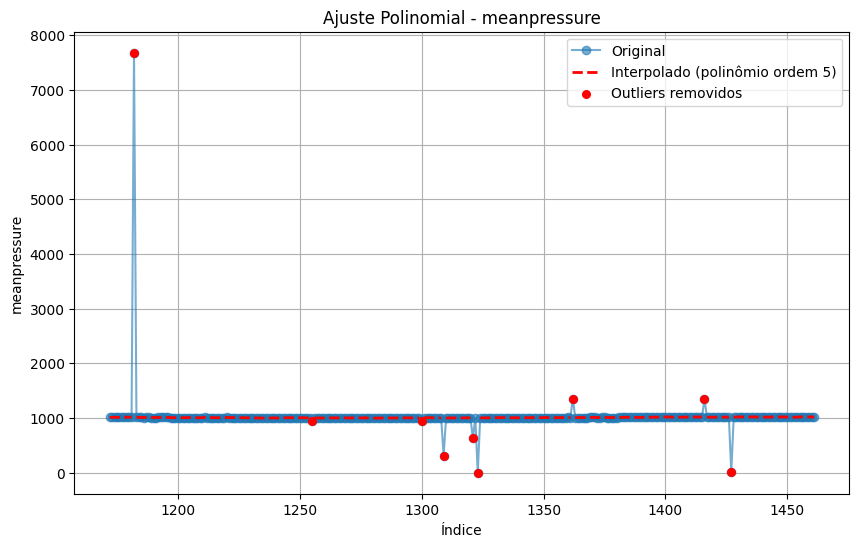

In [ ]:
# Coluna a ser analisada
col = 'meanpressure'

# Índices dos outliers
out_idx = outliers_meanpressure.index

# Escolher uma janela em torno dos outliers para visualização
# (por exemplo, 10 pontos antes e depois do primeiro outlier)
i0 = out_idx[0]
window = range(max(0, i0 - 10), len(train_ds2))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(window, train_ds[col].iloc[window], 'o-', label='Original', alpha=0.6)
plt.plot(window, train_ds2[col].iloc[window], 'r--', label='Interpolado (polinômio ordem 5)', linewidth=2)

# Destacar os outliers
plt.scatter(out_idx, train_ds[col].iloc[out_idx], color='red', s=30, label='Outliers removidos', zorder=5)

plt.title(f"Ajuste Polinomial - {col}")
plt.xlabel("Índice")
plt.ylabel(col)
plt.legend()
plt.grid(True)
plt.show()


## Teste de estacionariedade

* ADF : H_0 : A série é não estacionária
* KPSS : H_0 : A série é estacionária

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_tests(series, name=""):
    series = series.dropna()

    adf_result = adfuller(series)
    kpss_result = kpss(series, regression='c', nlags='auto')

    print(f"\nResultados para: {name}")

    print("\nADF Test:")
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")

    print("\nKPSS Test:")
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"p-value: {kpss_result[1]:.4f}")


In [ ]:
stationarity_tests(train_ds2['meanpressure'], "meanpressure")


Resultados para: meanpressure

ADF Test:
ADF Statistic: -2.1351
p-value: 0.2306

KPSS Test:
KPSS Statistic: 0.0942
p-value: 0.1000


/tmp/ipython-input-3187613491.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


In [ ]:
stationarity_tests(train_ds2['meantemp'], "meantemp")


Resultados para: meantemp

ADF Test:
ADF Statistic: -2.0103
p-value: 0.2821

KPSS Test:
KPSS Statistic: 0.1821
p-value: 0.1000


/tmp/ipython-input-3187613491.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


In [ ]:
stationarity_tests(train_ds2['humidity'], "humidity")


Resultados para: humidity

ADF Test:
ADF Statistic: -3.6916
p-value: 0.0042

KPSS Test:
KPSS Statistic: 0.0924
p-value: 0.1000


/tmp/ipython-input-3187613491.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


In [ ]:
stationarity_tests(train_ds2['wind_speed'], "wind_speed")


Resultados para: wind_speed

ADF Test:
ADF Statistic: -3.8460
p-value: 0.0025

KPSS Test:
KPSS Statistic: 0.1403
p-value: 0.1000


/tmp/ipython-input-3187613491.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


Os testes indicam que wind_speed e humidity são estacionárias

Entretanto, houve discordância entre os testes sobre a estacionariedade de meantemp e meanpressure. Provavelmente possue fraca tendência, sazonalidade ou são quase estacionárias;

## Análise Exploratória


### Gráficos

In [ ]:
train_ds2.shape

(1462, 5)

In [ ]:
train_ds2.drop('date', axis=1).describe()

meantemp     humidity   wind_speed  meanpressure
count  1453.000000  1453.000000  1453.000000   1453.000000
mean     25.474857    60.771971     6.794871   1008.269018
std       7.358206    16.783908     4.566871      7.437835
min       6.000000    13.428571     0.000000    991.375000
25%      18.750000    50.375000     3.475000   1001.625000
50%      27.714286    62.625000     6.166667   1008.571429
75%      31.285714    72.250000     9.202941   1014.937500
max      38.714286   100.000000    42.220000   1023.000000

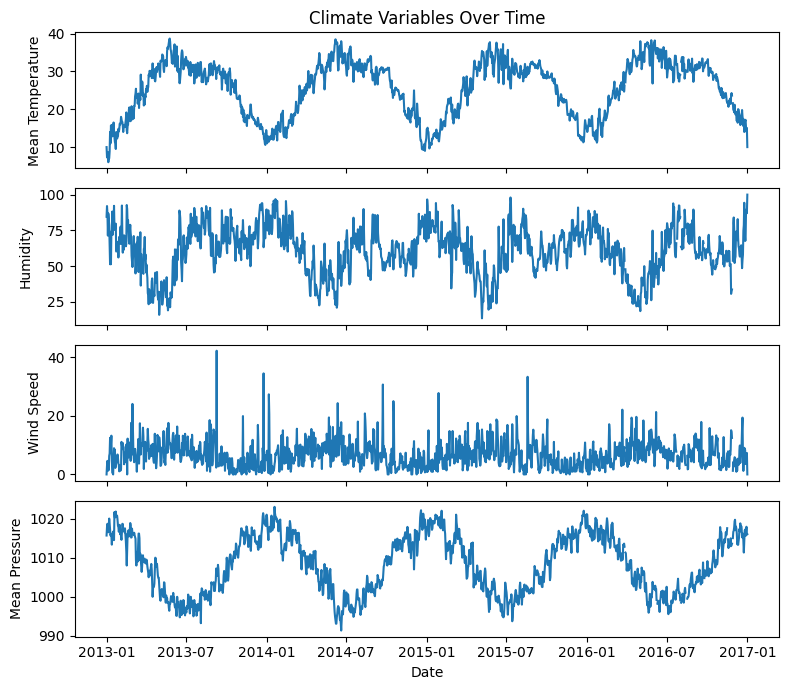

In [ ]:
# Plot das séries univariadas

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 7), sharex=True)

axes[0].plot(train_ds2['date'], train_ds2['meantemp'])
axes[0].set_ylabel('Mean Temperature')
axes[0].set_title('Climate Variables Over Time')

axes[1].plot(train_ds2['date'], train_ds2['humidity'])
axes[1].set_ylabel('Humidity')

axes[2].plot(train_ds2['date'], train_ds2['wind_speed'])
axes[2].set_ylabel('Wind Speed')

axes[3].plot(train_ds2['date'], train_ds2['meanpressure'])
axes[3].set_ylabel('Mean Pressure')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

### Análise de tendência

In [ ]:
!pip install pymannkendall

In [ ]:
import pymannkendall as mk
from scipy.stats import kruskal


In [ ]:
result = mk.original_test(train_ds2['meantemp'])
print(result)

Mann_Kendall_Test(trend='increasing', h=np.True_, p=np.float64(1.3714934592012895e-05), z=np.float64(4.34837596829003), Tau=np.float64(0.07614245438809038), s=np.float64(80321.0), var_s=np.float64(341187589.6666667), slope=np.float64(0.0017510329508008313), intercept=np.float64(26.443035792004313))


A série meantemp possui crescente tendência fraca

In [ ]:
result = mk.original_test(train_ds2['humidity'])
print(result)


Mann_Kendall_Test(trend='decreasing', h=np.True_, p=np.float64(0.0058138263607505625), z=np.float64(-2.7581008205900597), Tau=np.float64(-0.048296580268049956), s=np.float64(-50947.0), var_s=np.float64(341192839.0), slope=np.float64(-0.002976190476190471), intercept=np.float64(64.78571428571428))


A série humidity possui tendencia decrescente fraca

In [ ]:
result = mk.original_test(train_ds2['wind_speed'])
print(result)

Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.42261117884070143), z=np.float64(-0.8018993557373841), Tau=np.float64(-0.014042382152248886), s=np.float64(-14813.0), var_s=np.float64(341183231.0), slope=np.float64(-0.00016475340136054637), intercept=np.float64(6.2862776360544235))


A série wind_speed não possui tendência

In [ ]:
result = mk.original_test(train_ds2['meanpressure'])
print(result)

Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.47950645061609753), z=np.float64(0.7070965969631527), Tau=np.float64(0.012382474561039285), s=np.float64(13062.0), var_s=np.float64(341189270.0), slope=np.float64(0.00032299741602067185), intercept=np.float64(1008.3369324473975))


a série mean_pressure não possui tendência

### Análise de sazonalidade

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram


#### Meantemp

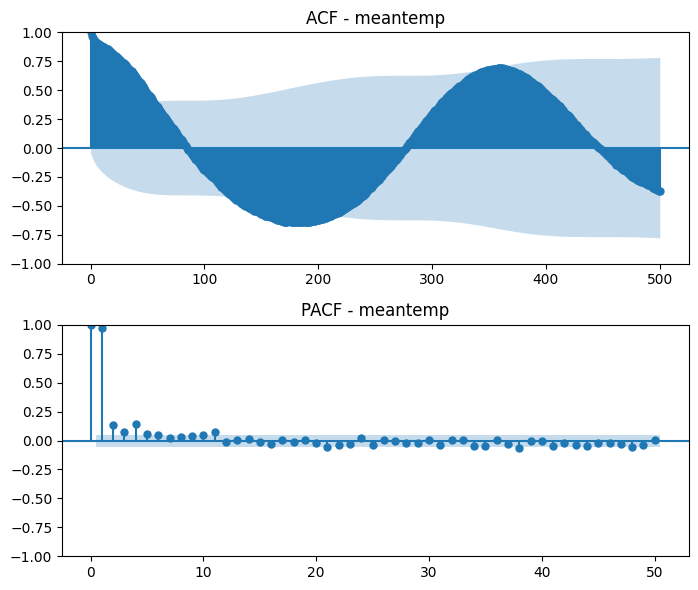

In [ ]:

serie = train_ds2['meantemp'].dropna()

fig, axes = plt.subplots(2, 1, figsize=(7, 6))

# ACF
plot_acf(serie, lags=500, ax=axes[0])
axes[0].set_title("ACF - meantemp")

# PACF
plot_pacf(serie, lags=50, ax=axes[1], method='ywm')  # método mais estável
axes[1].set_title("PACF - meantemp")

plt.tight_layout()
plt.show()



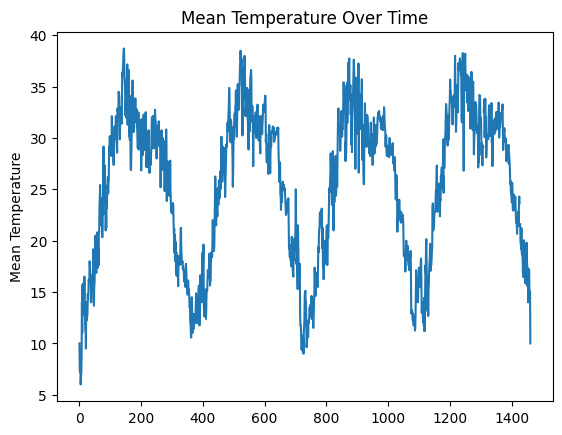

In [ ]:
plt.plot(train_ds2['meantemp'])
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Over Time')
plt.show()

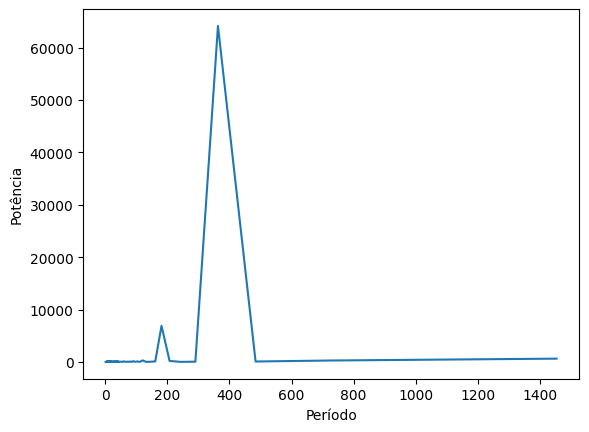

In [ ]:

series = train_ds2['meantemp'].dropna().values
freqs, power = periodogram(series)

# evita frequência zero
freqs = freqs[1:]
power = power[1:]

dominant_freq = freqs[np.argmax(power)]
period = 1 / dominant_freq

plt.plot(1/freqs, power)
plt.xlabel("Período")
plt.ylabel("Potência")
plt.show()


In [ ]:
min_period = 60       # ajuste conforme seu caso
mask = (1 / freqs) >= min_period

freqs_f = freqs[mask]
power_f = power[mask]


In [ ]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(power_f,
                      height=np.percentile(power_f, 95),
                      distance=10)

peak_periods = 1 / freqs_f[peaks]
peak_powers = power_f[peaks]

idx = np.argsort(peak_powers)[::-1]

for p, pow_ in zip(peak_periods[idx][:5], peak_powers[idx][:5]):
    print(f"Período ≈ {p:.1f} | Potência = {pow_:.2f}")


Período ≈ 363.2 | Potência = 64138.57


A série possue período de 365.5 anos

#### Humidity_no_trend

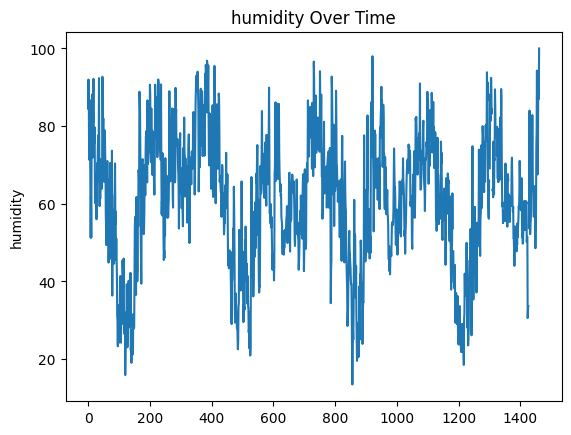

In [ ]:
plt.plot(train_ds2['humidity'])
plt.ylabel('humidity')
plt.title('humidity Over Time')
plt.show()

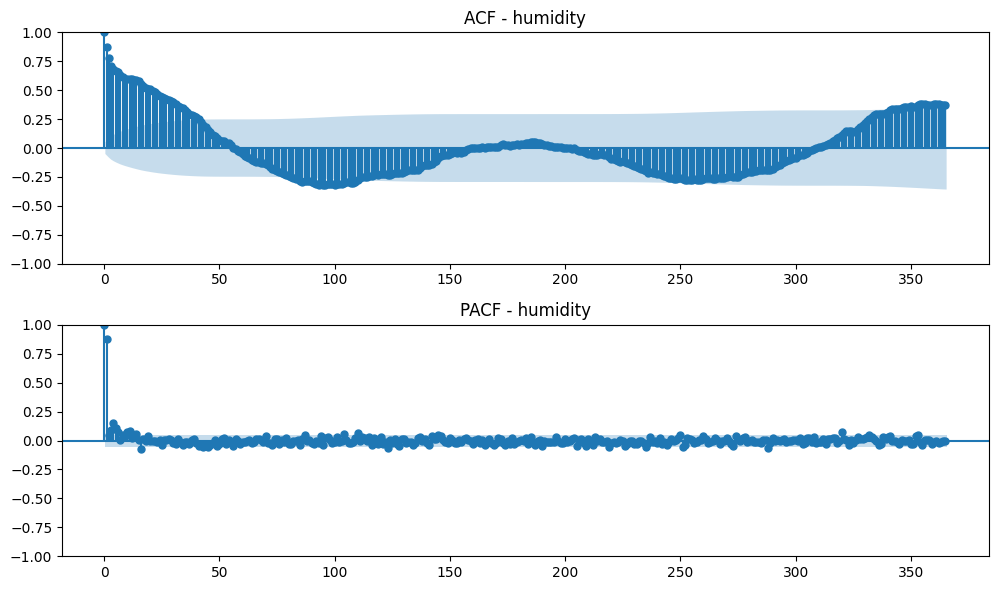

In [ ]:

serie = train_ds2['humidity'].dropna()

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# ACF
plot_acf(serie, lags=365, ax=axes[0])
axes[0].set_title("ACF - humidity")

# PACF
plot_pacf(serie, lags=365, ax=axes[1], method='ywm')  # método mais estável
axes[1].set_title("PACF - humidity")

plt.tight_layout()
plt.show()



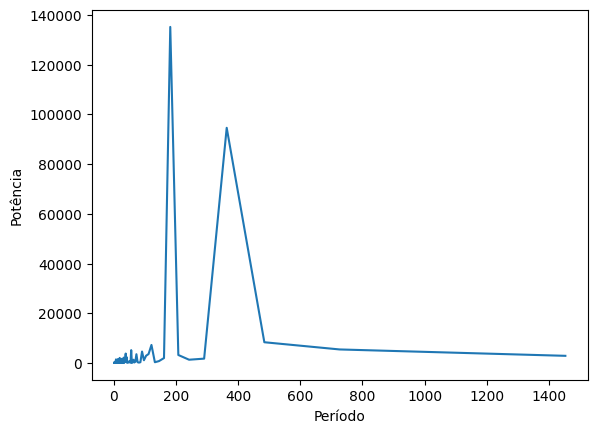

In [ ]:

series = train_ds2['humidity'].dropna().values
freqs, power = periodogram(series)

# evita frequência zero
freqs = freqs[1:]
power = power[1:]

dominant_freq = freqs[np.argmax(power)]
period = 1 / dominant_freq

plt.plot(1/freqs, power)
plt.xlabel("Período")
plt.ylabel("Potência")
plt.show()


In [ ]:
min_period = 60       # ajuste conforme seu caso
mask = (1 / freqs) >= min_period

freqs_f = freqs[mask]
power_f = power[mask]


In [ ]:
from scipy.signal import find_peaks
import numpy as np

# Assumindo que power_f (potência do periodograma) e freqs_f (frequências) estão definidos.
# Substitua as linhas acima com seus dados reais, se necessário.

peaks, _ = find_peaks(power_f,
                      height=np.percentile(power_f, 95), # Filtra picos que estão acima do percentil 95
                      distance=1)                       # Garante que picos estejam separados por 10 pontos

# Calcula o período (1/frequência)
peak_periods = 1 / freqs_f[peaks]
peak_powers = power_f[peaks]

# Ordena os índices em ordem decrescente de potência
idx = np.argsort(peak_powers)[::-1]

print("--- 2 Maiores Picos de Potência ---")

# Itera APENAS sobre os 2 primeiros índices ordenados [idx[:2]]
for p, pow_ in zip(peak_periods[idx][:2], peak_powers[idx][:2]):
    print(f"Período ≈ {p:.1f} | Potência = {pow_:.2f}")

print("-----------------------------------")

--- 2 Maiores Picos de Potência ---
Período ≈ 181.6 | Potência = 135195.92
Período ≈ 363.2 | Potência = 94600.57
-----------------------------------


A série humidity possue dois períodos sazonais dominantes: um ciclo de meio ano e um ciclo anual;

#### wind_speed



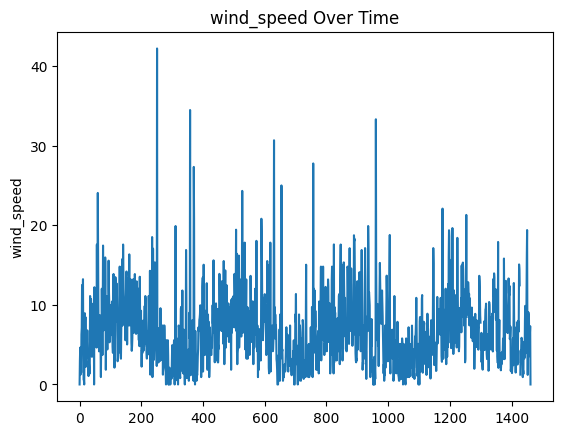

In [ ]:
plt.plot(train_ds2['wind_speed'])
plt.ylabel('wind_speed')
plt.title('wind_speed Over Time')
plt.show()

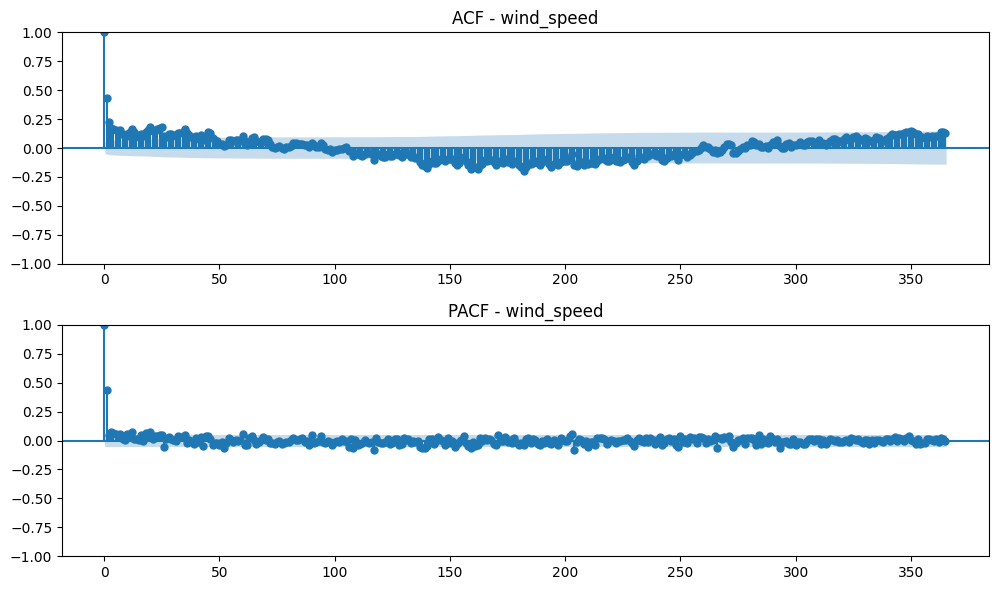

In [ ]:

serie = train_ds2['wind_speed'].dropna()

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# ACF
plot_acf(serie, lags=365, ax=axes[0])
axes[0].set_title("ACF - wind_speed")

# PACF
plot_pacf(serie, lags=365, ax=axes[1], method='ywm')  # método mais estável
axes[1].set_title("PACF - wind_speed")

plt.tight_layout()
plt.show()



acf mostra que há um comportamento sazonal

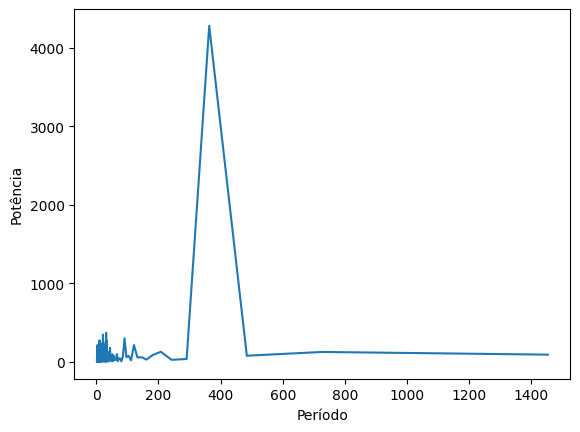

In [ ]:

series = train_ds2['wind_speed'].dropna().values
freqs, power = periodogram(series)

# evita frequência zero
freqs = freqs[1:]
power = power[1:]

dominant_freq = freqs[np.argmax(power)]
period = 1 / dominant_freq

plt.plot(1/freqs, power)
plt.xlabel("Período")
plt.ylabel("Potência")
plt.show()


In [ ]:
min_period = 60       # ajuste conforme seu caso
mask = (1 / freqs) >= min_period

freqs_f = freqs[mask]
power_f = power[mask]


In [ ]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(power_f,
                      height=np.percentile(power_f, 95),
                      distance=10)

peak_periods = 1 / freqs_f[peaks]
peak_powers = power_f[peaks]

idx = np.argsort(peak_powers)[::-1]

for p, pow_ in zip(peak_periods[idx][:5], peak_powers[idx][:5]):
    print(f"Período ≈ {p:.1f} | Potência = {pow_:.2f}")


Período ≈ 363.2 | Potência = 4276.59
Período ≈ 90.8 | Potência = 301.19


período anual

#### meanpressure

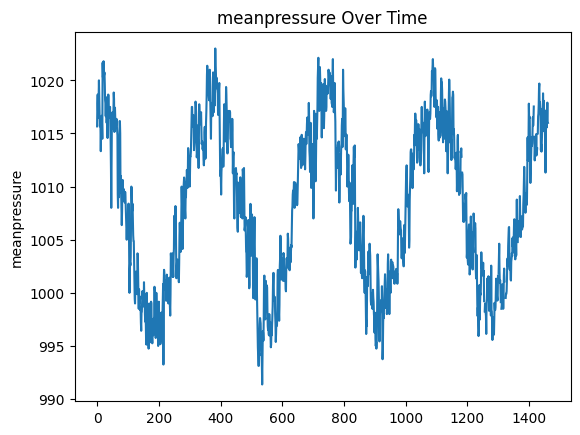

In [ ]:
plt.plot(train_ds2['meanpressure'])
plt.ylabel('meanpressure')
plt.title('meanpressure Over Time')
plt.show()

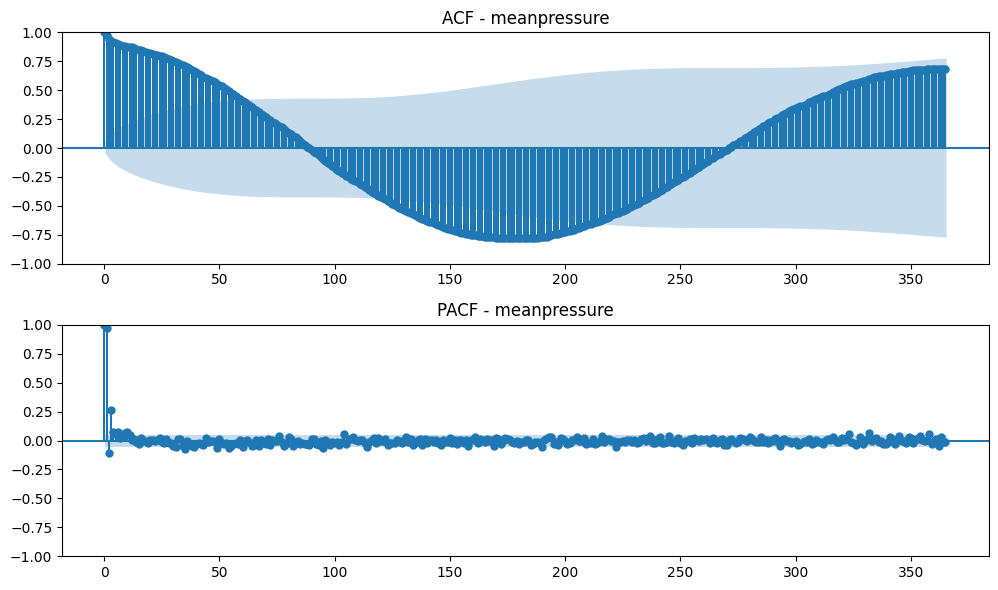

In [ ]:

serie = train_ds2['meanpressure'].dropna()

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# ACF
plot_acf(serie, lags=365, ax=axes[0])
axes[0].set_title("ACF - meanpressure")

# PACF
plot_pacf(serie, lags=365, ax=axes[1], method='ywm')  # método mais estável
axes[1].set_title("PACF - meanpressure")

plt.tight_layout()
plt.show()



acf mostra que há um comportamento sazonal

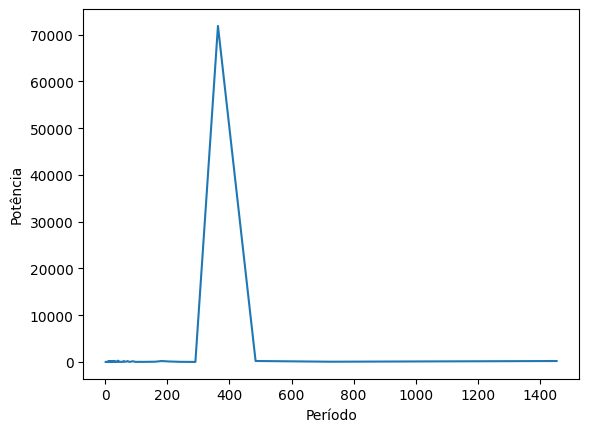

In [ ]:

series = train_ds2['meanpressure'].dropna().values
freqs, power = periodogram(series)

# evita frequência zero
freqs = freqs[1:]
power = power[1:]

dominant_freq = freqs[np.argmax(power)]
period = 1 / dominant_freq

plt.plot(1/freqs, power)
plt.xlabel("Período")
plt.ylabel("Potência")
plt.show()


In [ ]:
from scipy.signal import find_peaks

min_period = 60       # ajuste conforme seu caso
mask = (1 / freqs) >= min_period

freqs_f = freqs[mask]
power_f = power[mask]

peaks, _ = find_peaks(power_f,
                      height=np.percentile(power_f, 95),
                      distance=10)

peak_periods = 1 / freqs_f[peaks]
peak_powers = power_f[peaks]

idx = np.argsort(peak_powers)[::-1]

for p, pow_ in zip(peak_periods[idx][:5], peak_powers[idx][:5]):
    print(f"Período ≈ {p:.1f} | Potência = {pow_:.2f}")


Período ≈ 363.2 | Potência = 71880.48


###sssss

In [ ]:
# Calculate descriptive statistics for the series
train_ds_numeric = train_ds2.drop('date', axis=1)
mean_stats = train_ds_numeric.mean()
std_dev_stats = train_ds_numeric.std()
skewness_stats = train_ds_numeric.skew()
kurtosis_stats = train_ds_numeric.kurtosis()

print("Mean of original series:")
print(mean_stats)

print("\nStandard Deviation of original series:")
print(std_dev_stats)

print("\nSkewness of original series:")
print(skewness_stats)

print("\nKurtosis of original series:")
print(kurtosis_stats)

Mean of original series:
meantemp          25.474857
humidity          60.771971
wind_speed         6.794871
meanpressure    1008.269018
dtype: float64

Standard Deviation of original series:
meantemp         7.358206
humidity        16.783908
wind_speed       4.566871
meanpressure     7.437835
dtype: float64

Skewness of original series:
meantemp       -0.441903
humidity       -0.344740
wind_speed      1.441443
meanpressure   -0.066975
dtype: float64

Kurtosis of original series:
meantemp       -0.945376
humidity       -0.308640
wind_speed      5.057697
meanpressure   -1.248475
dtype: float64


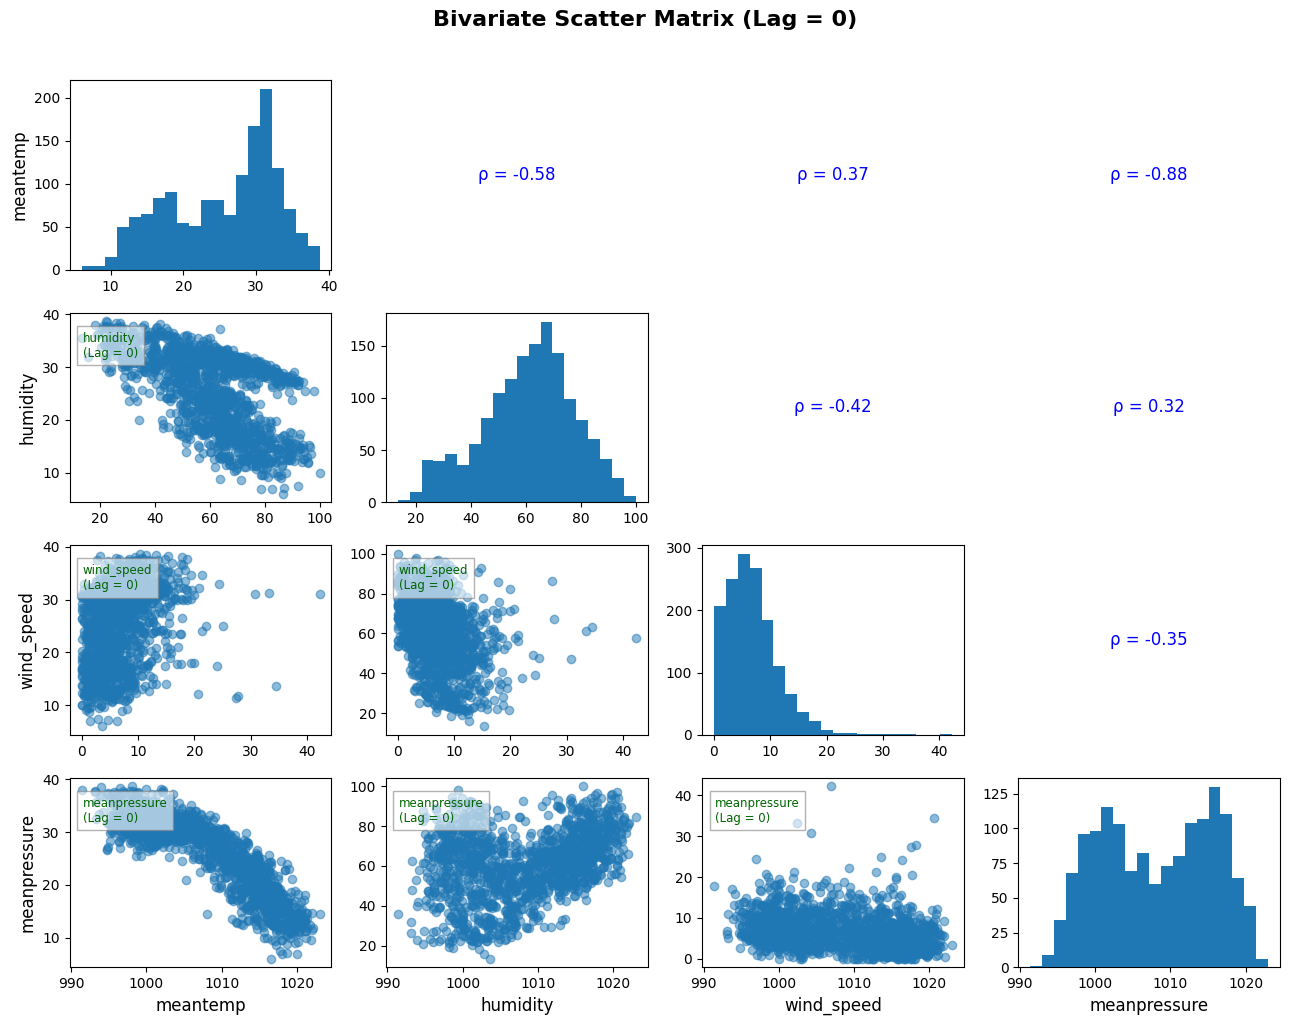

In [ ]:
plot_bivariate_scatter(train_ds2.drop('date', axis=1), lag=0, size=(13,10))

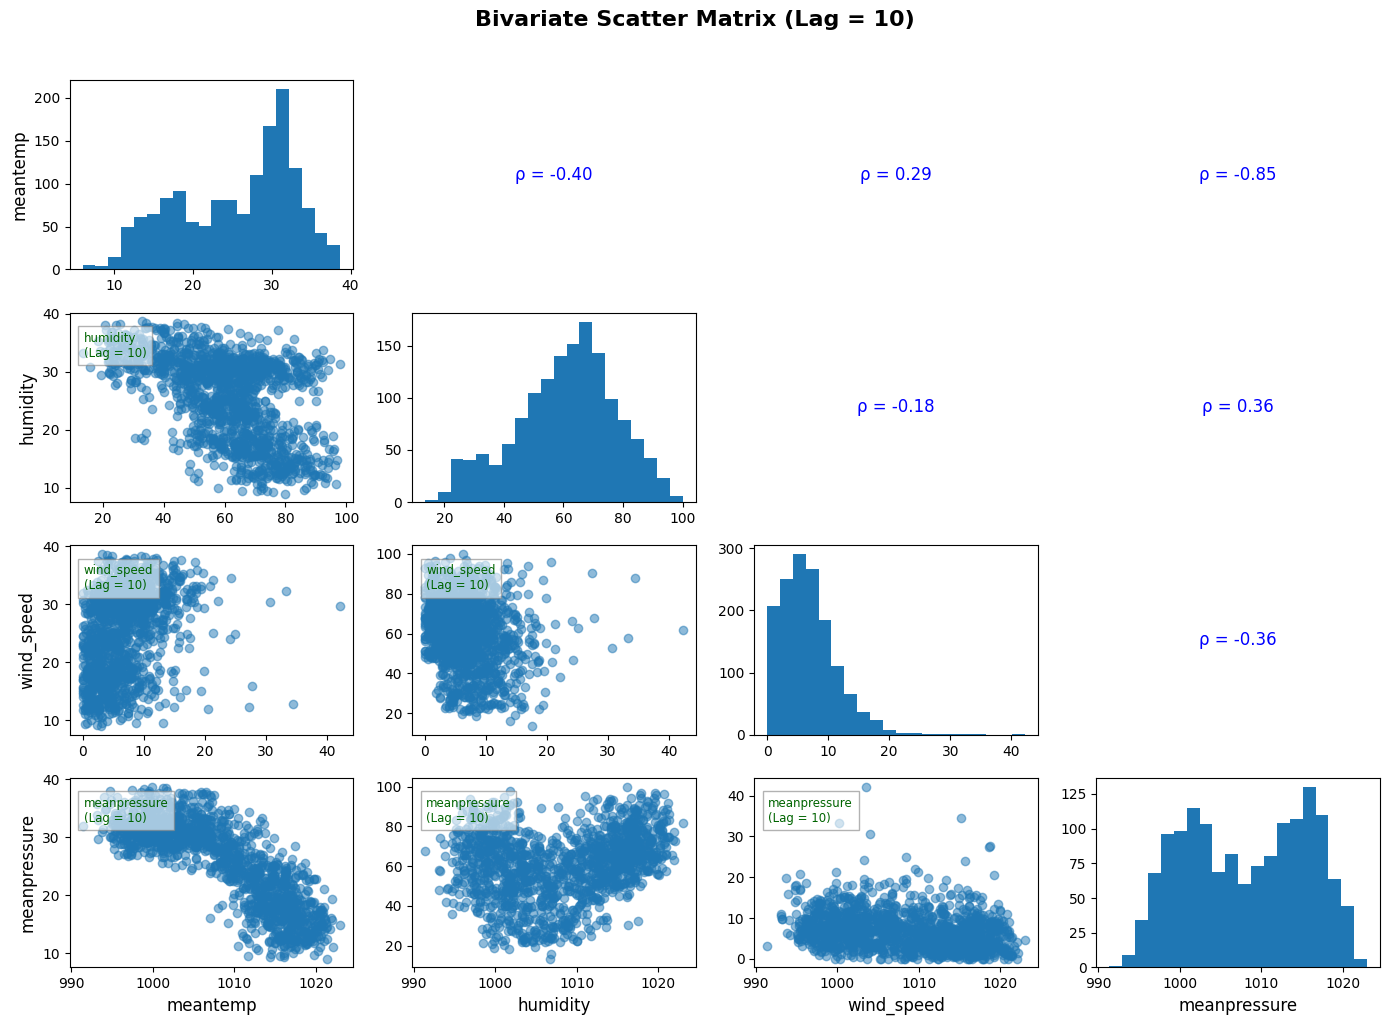

In [ ]:
plot_bivariate_scatter(train_ds2.drop('date', axis=1), lag=10, size=(14,10))

## Correlação Cruzada + Seasonal Plot

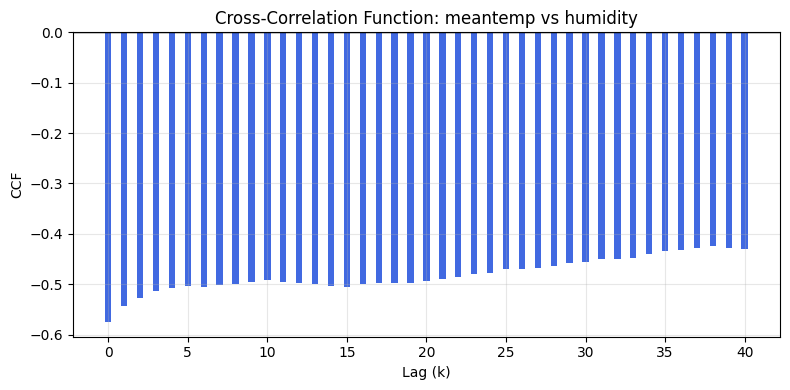

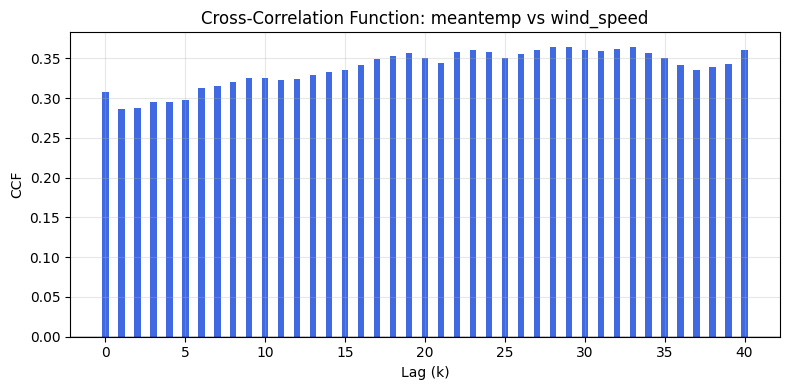

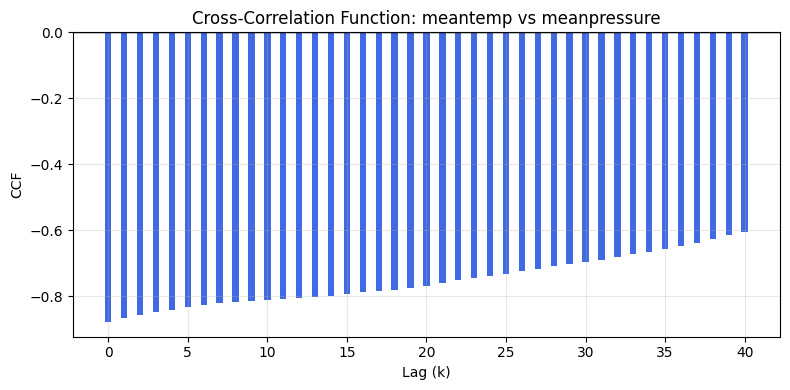

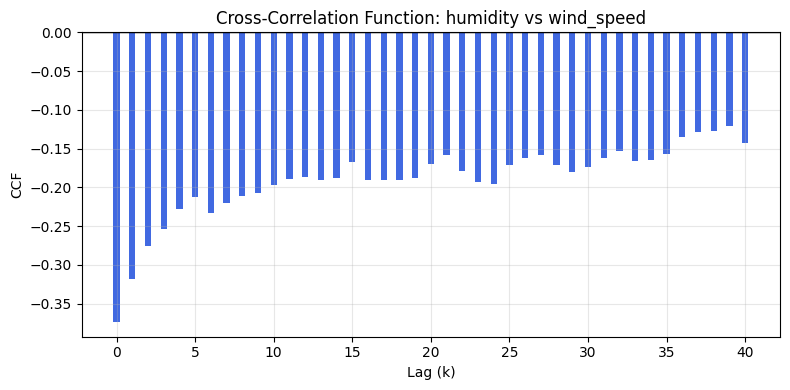

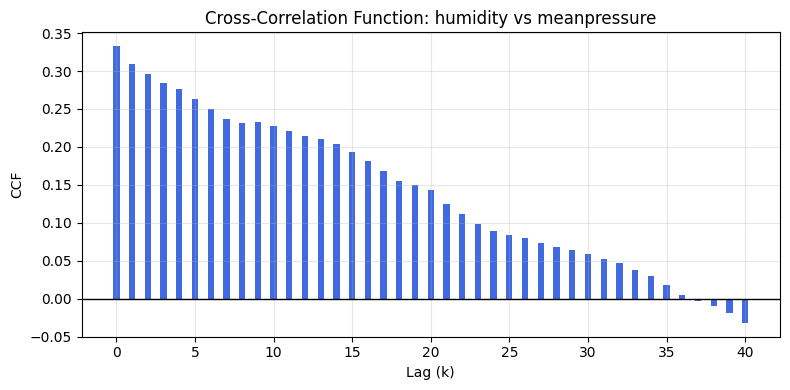

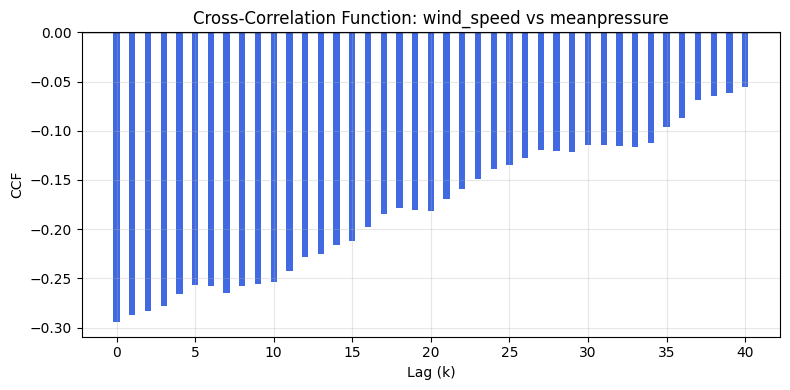

In [ ]:
plot_pairwise_crosscorrelations(train_ds2, max_lag=40)


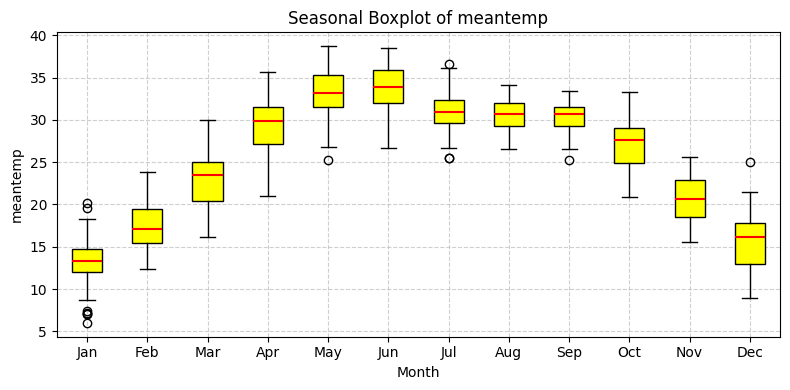

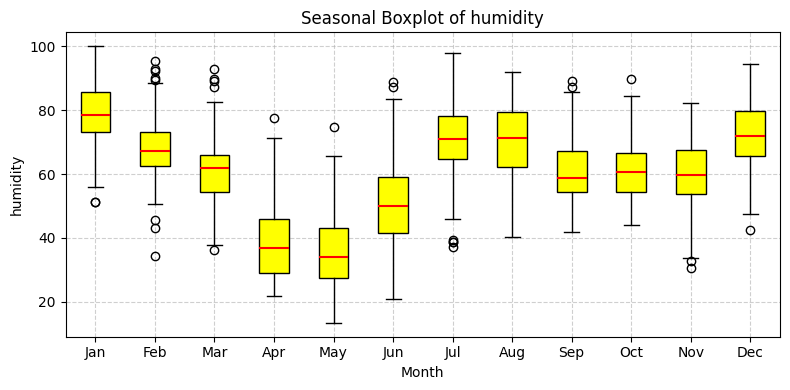

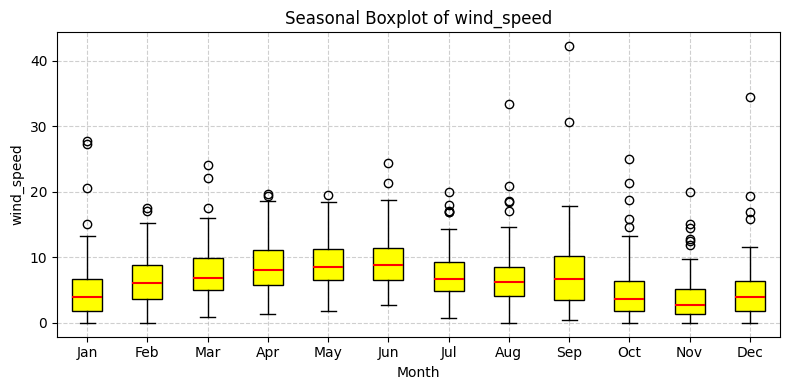

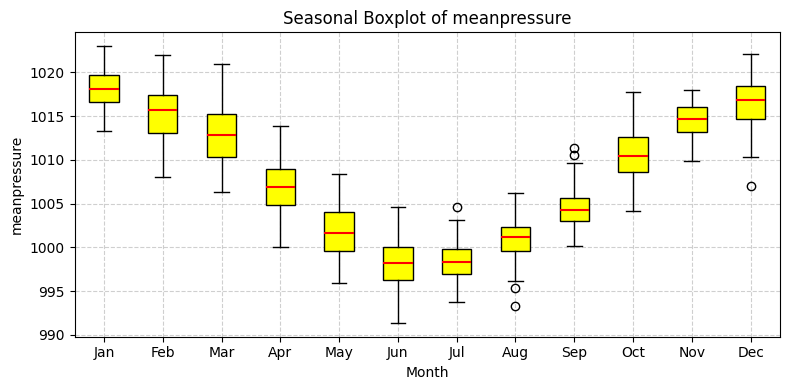

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Garantir que 'date' está em formato datetime
train_ds2['date'] = pd.to_datetime(train_ds2['date'])

# Extrair ano e mês
train_ds2['year'] = train_ds2['date'].dt.year
train_ds2['month'] = train_ds2['date'].dt.month

# Selecionar colunas numéricas (exceto year e month)
numerical_cols = train_ds2.select_dtypes(include=np.number).columns.drop(['year', 'month'], errors='ignore')

# Cria boxplots mensais para cada variável numérica
for col in numerical_cols:
    plt.figure(figsize=(8, 4))

    # Agrupar por mês
    grouped = [train_ds2.loc[train_ds2['month'] == m, col].dropna() for m in range(1, 13)]

    # Criar o boxplot
    plt.boxplot(grouped, patch_artist=True,
                boxprops=dict(facecolor='yellow', color='black'),
                medianprops=dict(color='red', linewidth=1.5))

    plt.xlabel('Month')
    plt.ylabel(col)
    plt.title(f'Seasonal Boxplot of {col}')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


train_ds2 = train_ds2.drop(['year', 'month'], axis=1)


meanpressure e meantemp tem um comportamento sazonal bem definido

## Feature Engineering

In [ ]:
train_ds3 = train_ds2.copy()

Variável binária para indicar se a pressão é baixa ou não

In [ ]:
train_ds3["is_low_pressure"] = pressure_condition

In [ ]:
train_ds3["is_low_pressure"].value_counts()

is_low_pressure
False    774
True     688
Name: count, dtype: int64

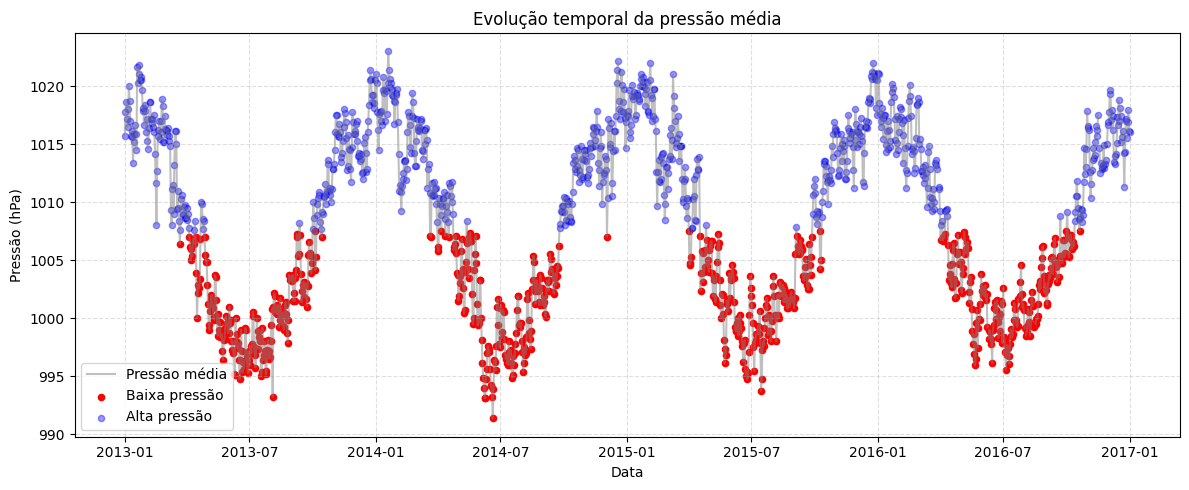

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Série original
plt.plot(train_ds3["date"], train_ds3["meanpressure"], color="gray", alpha=0.5, label="Pressão média")

# Destacar regiões de baixa pressão
plt.scatter(
    train_ds3.loc[train_ds3["is_low_pressure"], "date"],
    train_ds3.loc[train_ds3["is_low_pressure"], "meanpressure"],
    color="red", label="Baixa pressão", s=20
)

# E as de alta pressão (opcional)
plt.scatter(
    train_ds3.loc[~train_ds3["is_low_pressure"], "date"],
    train_ds3.loc[~train_ds3["is_low_pressure"], "meanpressure"],
    color="blue", label="Alta pressão", s=20, alpha=0.4
)

plt.title("Evolução temporal da pressão média")
plt.xlabel("Data")
plt.ylabel("Pressão (hPa)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


funções periódicas para capturar sazonalidade

In [ ]:
train_ds3["dayofyear"] = train_ds3["date"].dt.dayofyear

train_ds3["sin_year"] = np.sin(2 * np.pi * train_ds3["dayofyear"] / 365)
# train_ds3["cos_year"] = np.cos(2 * np.pi * train_ds3["dayofyear"] / 365) #alta correlação com pressure_ma50

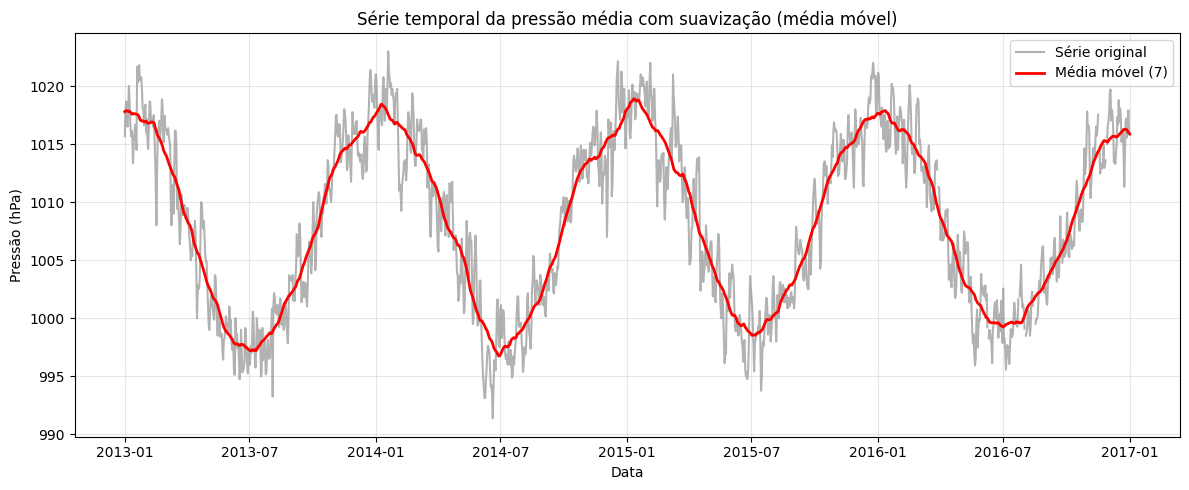

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# --- calcula a média móvel de 50 dias (pode ajustar a janela) ---
train_ds3["pressure_ma50"] = train_ds3["meanpressure"].rolling(window=50, center=True, min_periods=1).mean()

# --- plota a série original e a média móvel ---
plt.figure(figsize=(12, 5))
plt.plot(train_ds3["date"], train_ds3["meanpressure"], label="Série original", color="gray", alpha=0.6)
plt.plot(train_ds3["date"], train_ds3["pressure_ma50"], label="Média móvel (7)", color="red", linewidth=2)
plt.title("Série temporal da pressão média com suavização (média móvel)")
plt.xlabel("Data")
plt.ylabel("Pressão (hPa)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


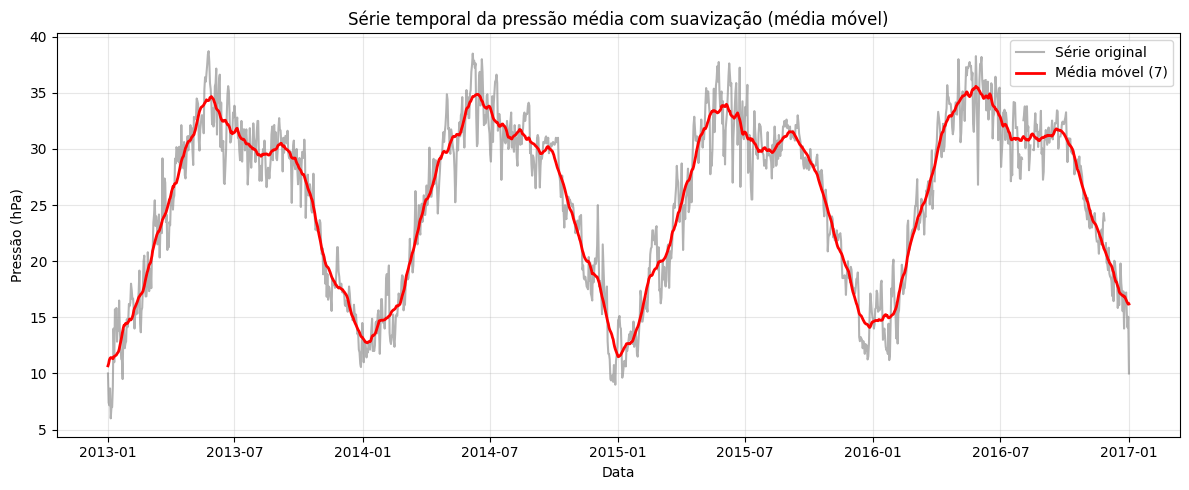

In [ ]:
# --- calcula a média móvel de 7 dias (pode ajustar a janela) ---
train_ds3["temp_ma50"] = train_ds3["meantemp"].rolling(window=30, center=True, min_periods=1).mean()

# --- plota a série original e a média móvel ---
plt.figure(figsize=(12, 5))
plt.plot(train_ds3["date"], train_ds3["meantemp"], label="Série original", color="gray", alpha=0.6)
plt.plot(train_ds3["date"], train_ds3["temp_ma50"], label="Média móvel (7)", color="red", linewidth=2)
plt.title("Série temporal da pressão média com suavização (média móvel)")
plt.xlabel("Data")
plt.ylabel("Pressão (hPa)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
train_ds3

date   meantemp    humidity  wind_speed  meanpressure  \
0    2013-01-01  10.000000   84.500000    0.000000   1015.666667   
1    2013-01-02   7.400000   92.000000    2.980000   1017.800000   
2    2013-01-03   7.166667   87.000000    4.633333   1018.666667   
3    2013-01-04   8.666667   71.333333    1.233333   1017.166667   
4    2013-01-05   6.000000   86.833333    3.700000   1016.500000   
...         ...        ...         ...         ...           ...   
1457 2016-12-28  17.217391   68.043478    3.547826   1015.565217   
1458 2016-12-29  15.238095   87.857143    6.000000   1016.904762   
1459 2016-12-30  14.095238   89.666667    6.266667   1017.904762   
1460 2016-12-31  15.052632   87.000000    7.325000   1016.100000   
1461 2017-01-01  10.000000  100.000000    0.000000   1016.000000   

      is_low_pressure  dayofyear      sin_year  pressure_ma50  temp_ma50  
0               False          1  1.721336e-02    1017.790190  10.679048  
1               False          2  3.442161e-02    1017.862363  10.876190  
2               False          3  5.161967e-02    1017.872751  11.207003  
3               False          4  6.880243e-02    1017.871344  11.352910  
4               False          5  8.596480e-02    1017.828366  11.413283  
...               ...        ...           ...            ...        ...  
1457            False        363 -3.442161e-02    1016.213193  16.532307  
1458            False        364 -1.721336e-02    1016.105602  16.399797  
1459            False        365  6.432491e-16    1015.977231  16.280033  
1460            False        366  1.721336e-02    1015.937667  16.169054  
1461            False          1  1.721336e-02    1015.859826  16.190037  

[1462 rows x 10 columns]

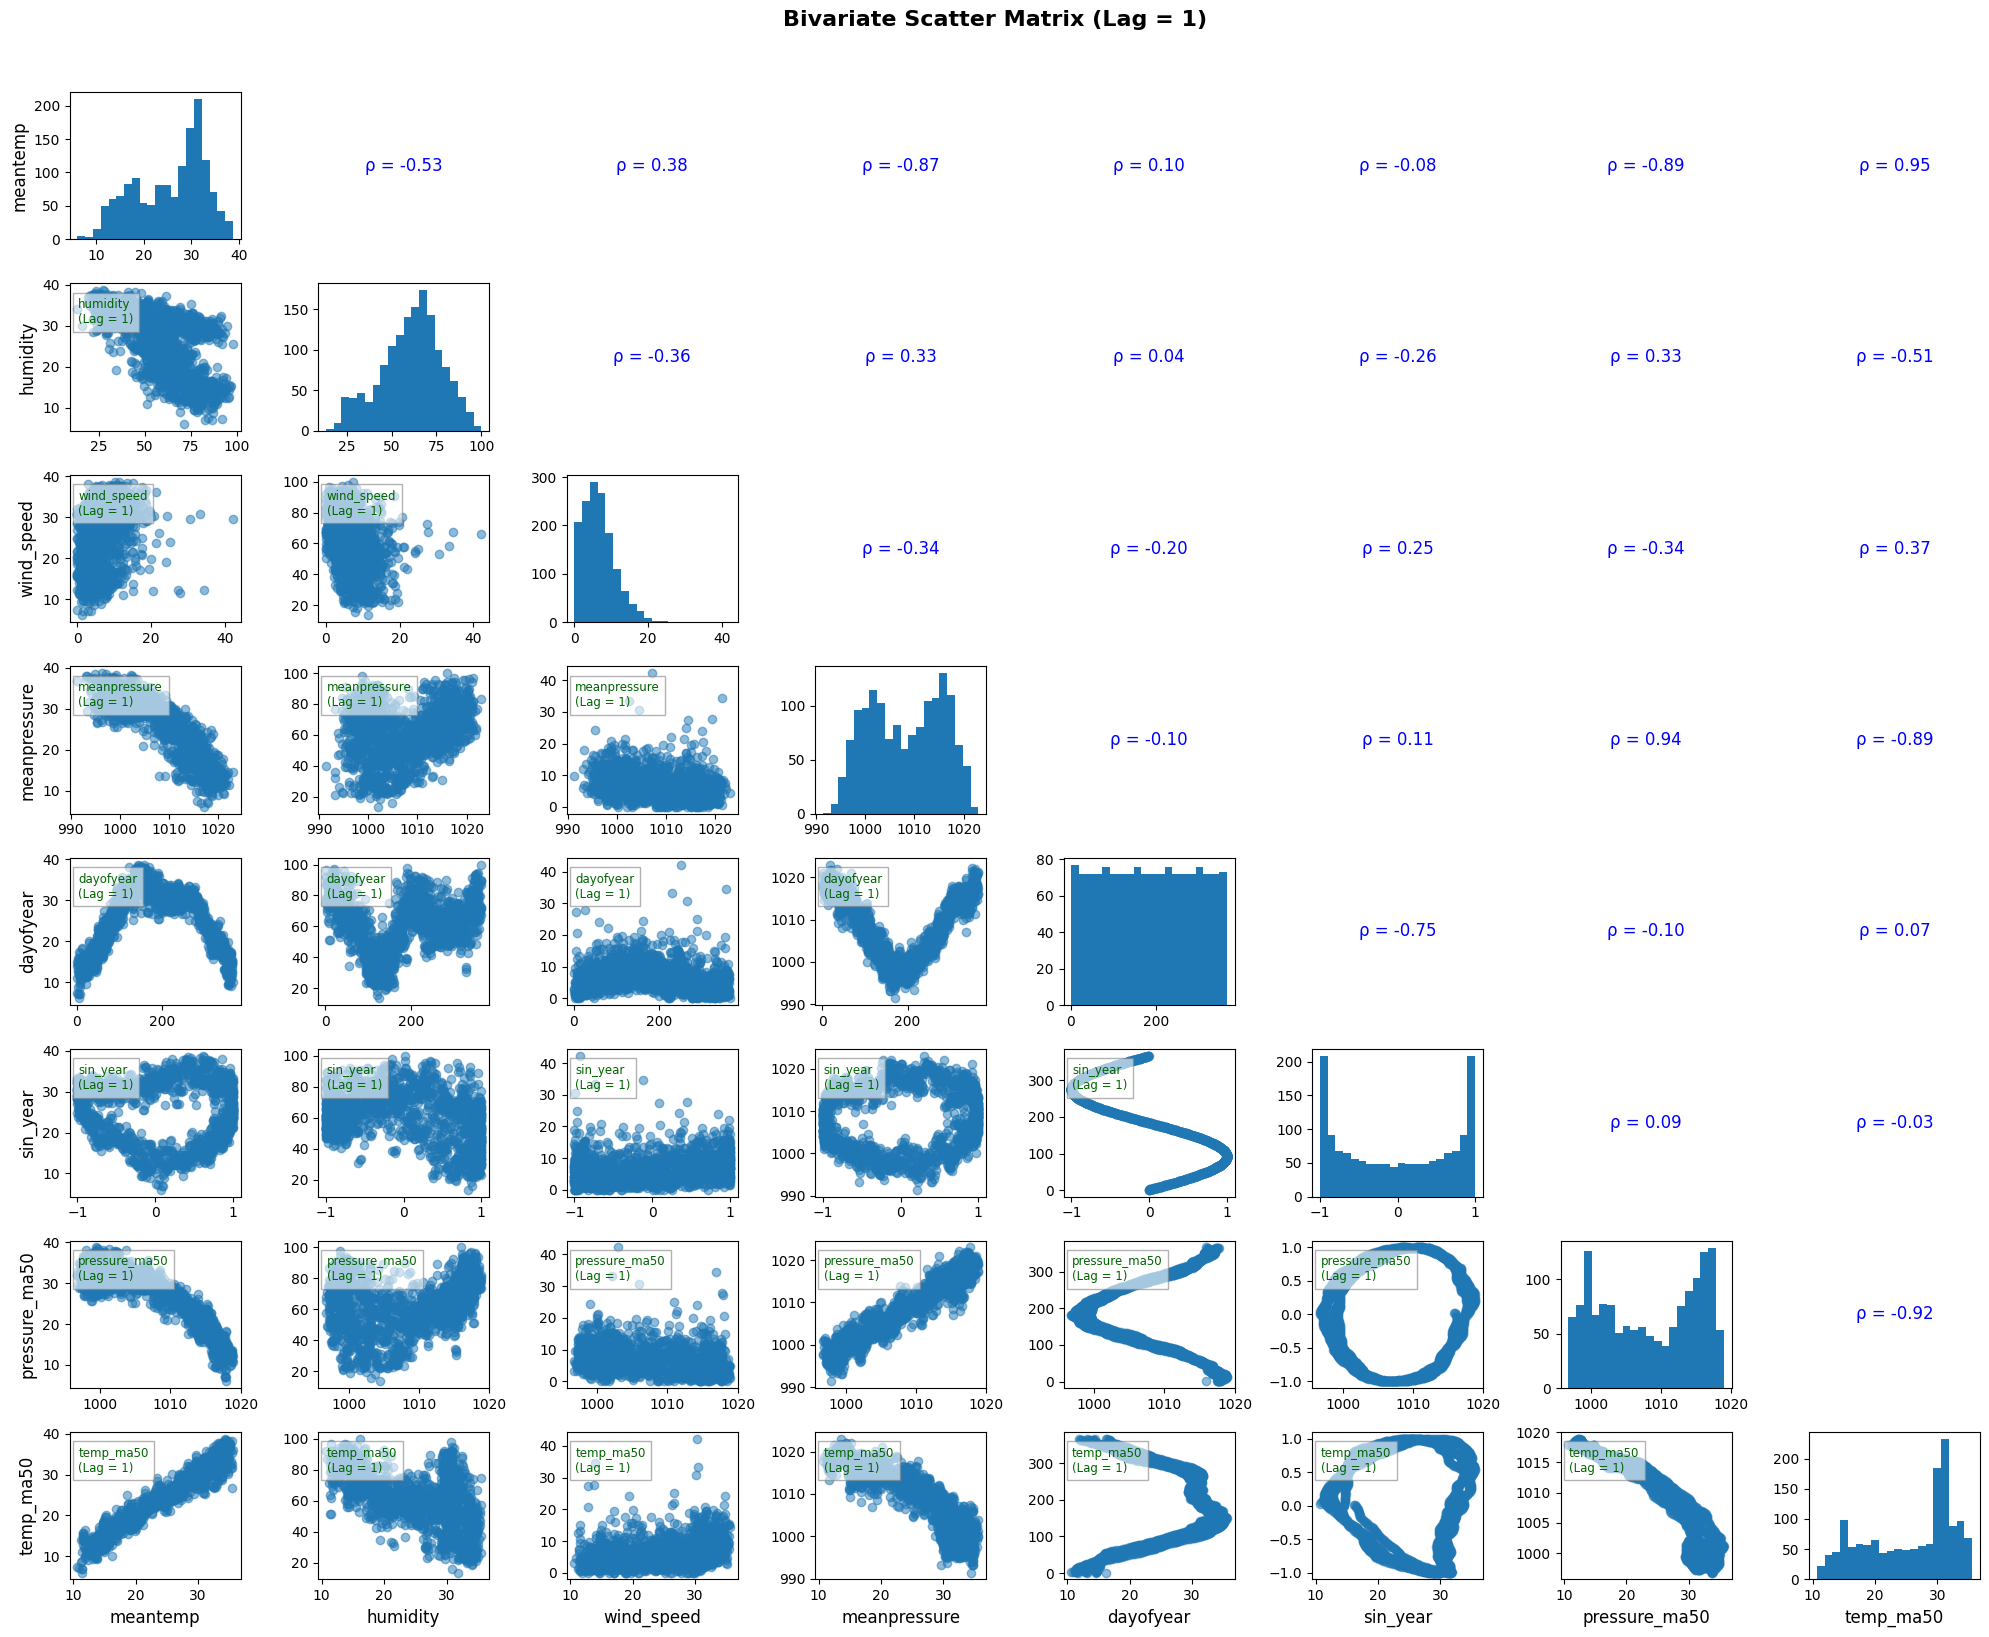

In [ ]:

plot_bivariate_scatter(train_ds3.drop(['date', 'is_low_pressure'], axis=1), lag=1, size=(20,16))

In [ ]:
train_ds3["season_half"] = (train_ds3["dayofyear"] > 180).astype(int)

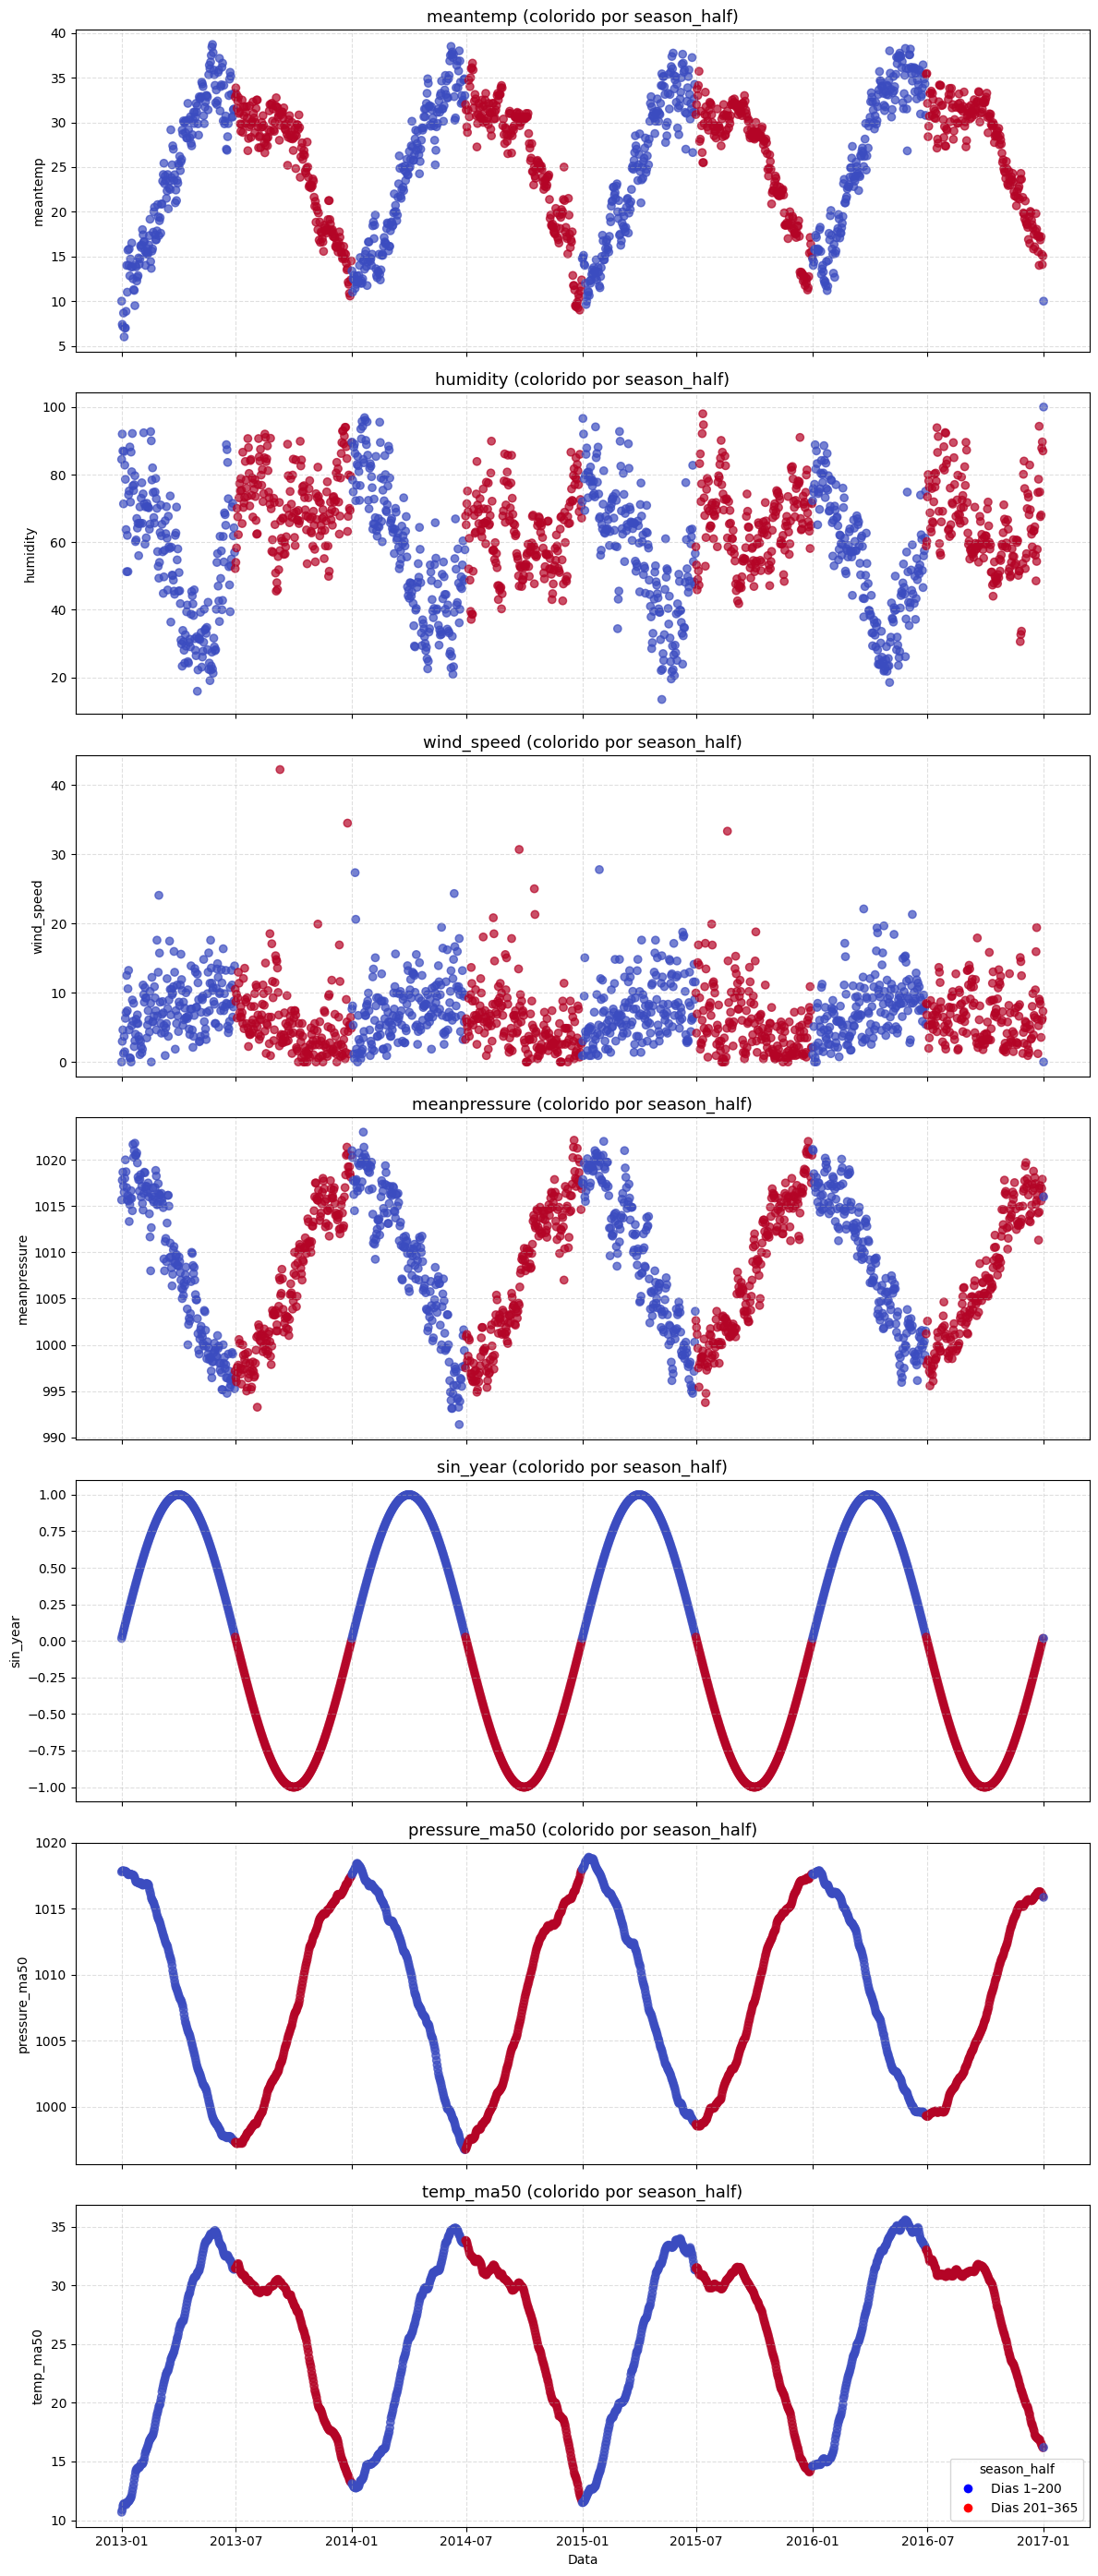

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Seleciona apenas as colunas numéricas (excluindo 'season_half' e 'dayofyear' se quiser)
numeric_cols = train_ds3.select_dtypes(include=['float64', 'int64']).columns.drop(["season_half", "dayofyear"], errors='ignore')

n = len(numeric_cols)
fig, axes = plt.subplots(n, 1, figsize=(12, 4*n), sharex=True)

if n == 1:
    axes = [axes]  # garante que axes seja iterável se só houver uma variável

for ax, col in zip(axes, numeric_cols):
    sc = ax.scatter(
        train_ds3["date"],
        train_ds3[col],
        c=train_ds3["season_half"],
        cmap="coolwarm",
        alpha=0.7
    )
    ax.set_title(f"{col} (colorido por season_half)", fontsize=13)
    ax.set_ylabel(col)
    ax.grid(True, linestyle="--", alpha=0.4)

# Legenda única
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Dias 1–200', markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Dias 201–365', markerfacecolor='red', markersize=8)
]
axes[-1].legend(handles=handles, title="season_half")

axes[-1].set_xlabel("Data")
plt.tight_layout()
plt.show()


# Prophet

## Forecast

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Prepare Prophet dataframe
prophet_df = train_ds2[['date', 'meantemp']].rename(
    columns={'date': 'ds', 'meantemp': 'y'}
)

# Create the model
model = Prophet(
    seasonality_mode="multiplicative",
    yearly_seasonality=10,
    weekly_seasonality=False,
    daily_seasonality=False
)
# Fit model
model.fit(prophet_df)

# Future dataframe (2 years)
future = model.make_future_dataframe(periods=365*2, freq='D')

# Forecast
forecast = model.predict(future)


## Plot

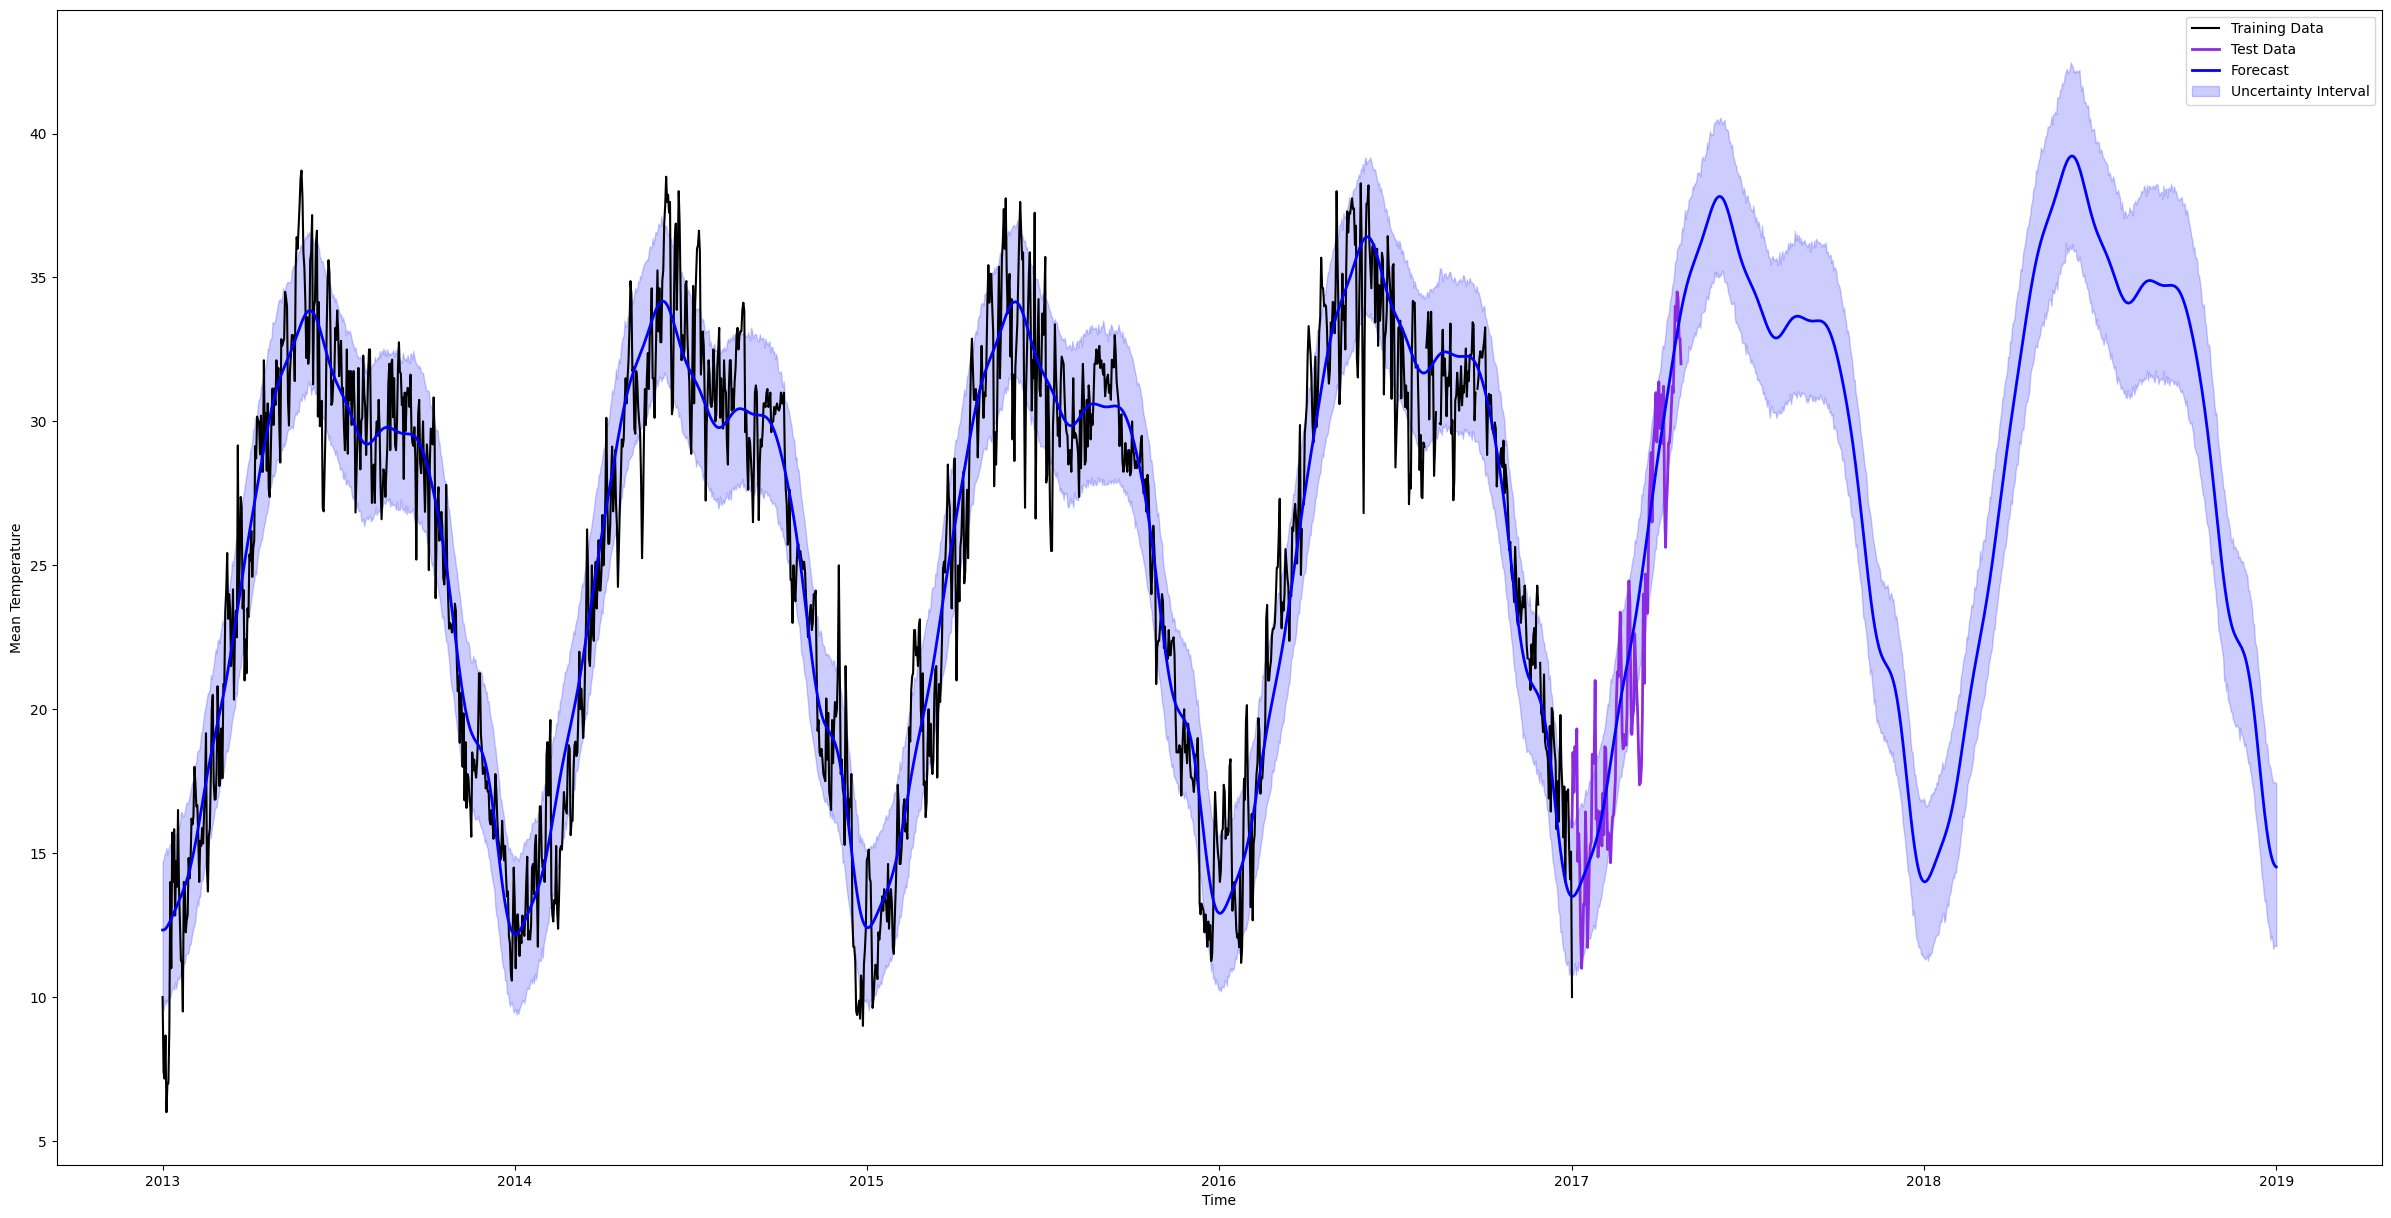

In [ ]:

# Preparar os dados de teste
test_prophet_df = test_ds[['date', 'meantemp']].rename(columns={'date': 'ds', 'meantemp': 'y'})

# Plot
fig, ax = plt.subplots(figsize=(30, 15))



# Plot the original training data as a line
ax.plot(prophet_df['ds'], prophet_df['y'], color='black', label='Training Data', linewidth=1.5)


# Plot the test data as a line
ax.plot(test_prophet_df['ds'], test_prophet_df['y'], color='blueviolet', label='Test Data', linewidth=2)

# Plot the Prophet forecast (mean and uncertainty)
ax.plot(forecast['ds'], forecast['yhat'], color='blue', label='Forecast', linewidth=2)
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Uncertainty Interval')


ax.set_ylabel('Mean Temperature')
ax.set_xlabel('Time')
ax.set_title('')
ax.legend()

plt.show()

## Components

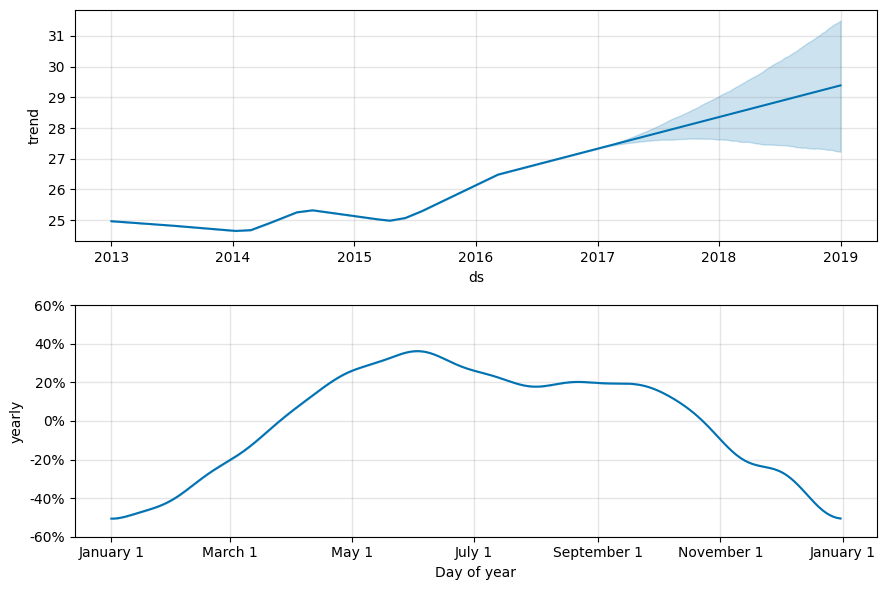

In [ ]:
fig = model.plot_components(forecast)

plt.show()

## Changepoints

In [ ]:
model.changepoints


46     2013-02-16
93     2013-04-04
139    2013-05-20
186    2013-07-06
232    2013-08-21
279    2013-10-07
325    2013-11-22
372    2014-01-08
418    2014-02-23
464    2014-04-10
511    2014-05-27
557    2014-07-12
604    2014-08-28
650    2014-10-13
697    2014-11-29
743    2015-01-14
789    2015-03-01
836    2015-04-17
882    2015-06-02
929    2015-07-19
975    2015-09-03
1022   2015-10-20
1068   2015-12-05
1115   2016-01-21
1161   2016-03-07
Name: ds, dtype: datetime64[ns]

## Error metrics

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Filter the forecast to align with the test data dates
forecast_test = forecast[forecast['ds'].isin(test_prophet_df['ds'])]

# Align the test_prophet_df with the forecast_test (important if there were missing dates in forecast_test originally)
test_aligned = test_prophet_df[test_prophet_df['ds'].isin(forecast_test['ds'])]

# Extract actual and predicted values
actual_values = test_aligned['y']
predicted_values = forecast_test['yhat']

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

print(f"Mean Absolute Error (MAE): {mae:.4f} °C")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f} °C")

Mean Absolute Error (MAE): 2.0810 °C
Root Mean Squared Error (RMSE): 2.5582 °C


## cross validation

In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(
    model,
    initial='730 days',
    period='180 days',
    horizon='365 days'
)

df_p = performance_metrics(df_cv)
df_p

INFO:prophet:Making 3 forecasts with cutoffs between 2015-01-07 00:00:00 and 2016-01-02 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

horizon       mse      rmse       mae      mape     mdape     smape  \
0    36 days  6.082139  2.466199  1.895474  0.112526  0.072934  0.113033   
1    37 days  5.825795  2.413668  1.832197  0.108607  0.068862  0.109233   
2    38 days  5.756927  2.399360  1.824037  0.107115  0.068862  0.107650   
3    39 days  5.595562  2.365494  1.788723  0.104888  0.067492  0.105285   
4    40 days  5.264536  2.294458  1.755417  0.102527  0.067492  0.102935   
..       ...       ...       ...       ...       ...       ...       ...   
325 361 days  9.200459  3.033226  2.649131  0.135360  0.121537  0.138119   
326 362 days  9.279947  3.046301  2.666823  0.137430  0.121537  0.140536   
327 363 days  9.189136  3.031359  2.656055  0.138383  0.121537  0.141739   
328 364 days  9.361628  3.059678  2.681488  0.140925  0.126674  0.144857   
329 365 days  9.167560  3.027798  2.657159  0.141411  0.126674  0.145528   

     coverage  
0    0.731481  
1    0.750000  
2    0.750000  
3    0.768519  
4    0.768519  
..        ...  
325  0.503086  
326  0.487654  
327  0.490741  
328  0.475309  
329  0.481481  

[330 rows x 8 columns]

## Plot das métricas por horizonte

/usr/local/lib/python3.12/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be remov

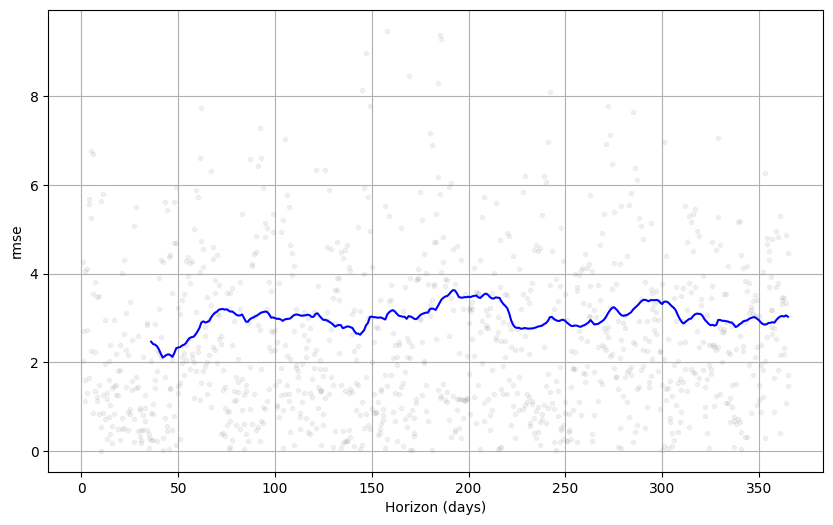

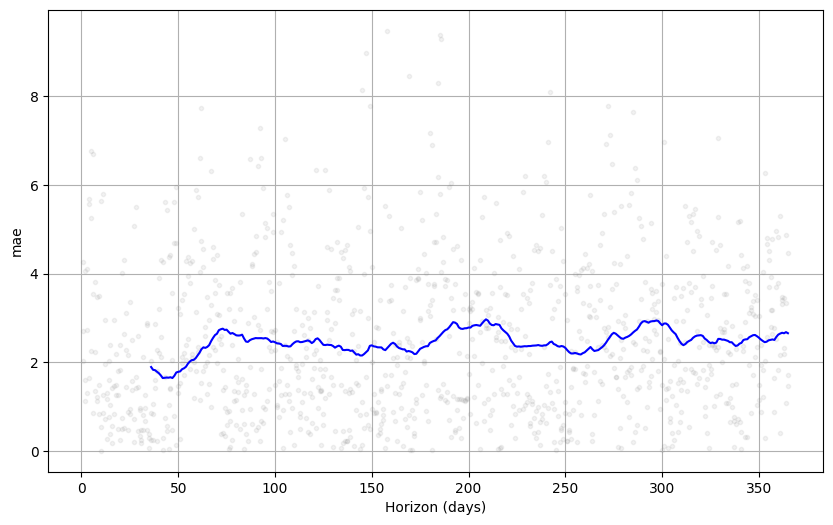

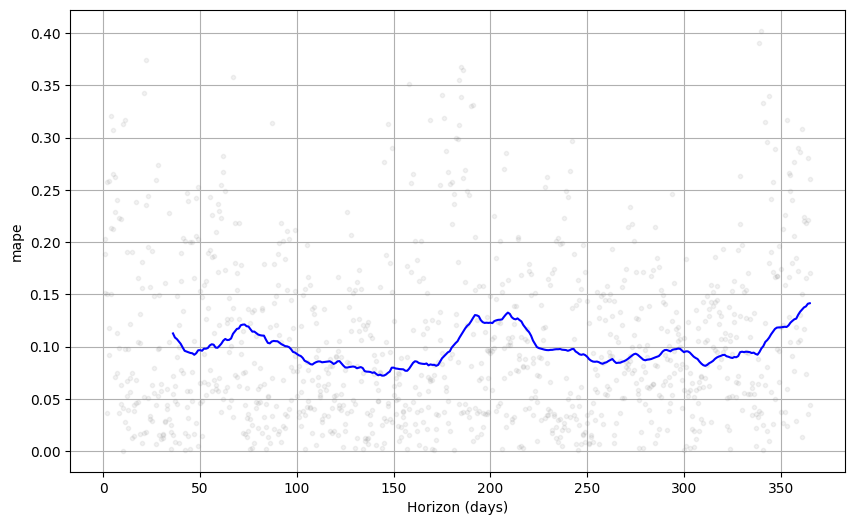

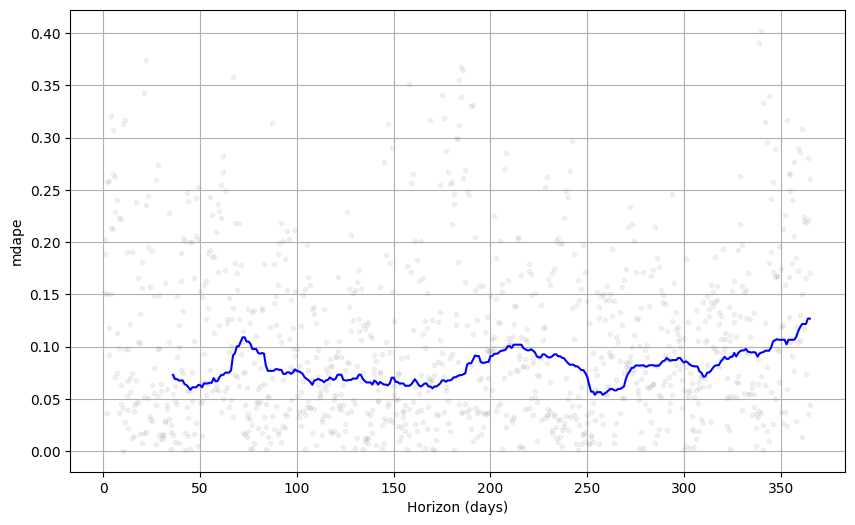

In [ ]:
from prophet.plot import plot_cross_validation_metric

plot_cross_validation_metric(df_cv, metric='rmse')
plot_cross_validation_metric(df_cv, metric='mae')
plot_cross_validation_metric(df_cv, metric='mape')
plot_cross_validation_metric(df_cv, metric='mdape')

plt.show()

## interpretar sazonalidade numericamente

In [ ]:
forecast['yearly'].describe()

count    2192.000000
mean       -0.000115
std         0.273750
min        -0.506195
25%        -0.240425
50%         0.113823
75%         0.202427
max         0.362239
Name: yearly, dtype: float64